<a href="https://colab.research.google.com/github/pranav168/NYC-Taxi-Trip-Time-Prediction/blob/main/NYC_Taxi_Trip_Time_Prediction_Final_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd                                                             # Importing all the required packages and libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime as dt
!pip install haversine
import haversine as hs
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
!pip install catboost
from catboost import CatBoostRegressor 

from mpl_toolkits.mplot3d import axes3d
from sklearn.metrics import r2_score,accuracy_score  
from sklearn.model_selection import train_test_split  
from xgboost import XGBRegressor
from sklearn import metrics
import warnings                                                                 # Removing all those annoying Warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  # This is added back by InteractiveShellApp.init_path()


     |████████████████████████████████| 67.4 MB 27 kB/s 


In [4]:
df=pd.read_csv('/content/drive/MyDrive/Copy of NYC Taxi Data.csv')              # Mounting Google Drive
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
df.info()                                                                       #No nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [6]:
column_list=['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration']
count_dataset=pd.DataFrame()
distinct_features=[]                                                                                          #Empty list to know the number of distict features,sum of all these values, and sum of values top 10 comprises
for i in column_list:                                                                                               
  count_dataset[i]= pd.Series(df[i].value_counts().sort_values(ascending=False).head(10).index)      
  count_dataset[f'{i}_count']=pd.Series(df[i].value_counts().sort_values(ascending=False).head(10).values).astype('int')   
  distinct_features.append((len(df[i].value_counts().index),df[i].value_counts().sum(),df[i].value_counts().sort_values(ascending=False).head(10).sum())) 
# final_tally=list(zip(column_list,distinct_features))                                                        #Zipping with column_list
col_ref={}  
for i in column_list:
  if i in ['trip_duration']:                                                                                  #colur red shows the Dependent Variable('trip_duration')
    col_ref[i]='background-color: red'  
  else:
    col_ref[i]='background-color: blue'                                                                       #colur blue shows the features 
  temp=f'{i}_count'
  col_ref[temp]='background-color: green'                                                                     #colur green shows the count
def Nan_as_black(val):
  if str(val)=='nan':
    color = 'black'
    return 'color: %s' % color
count_dataset=count_dataset.style.apply(lambda x: pd.DataFrame(col_ref, index=count_dataset.index, columns=count_dataset.columns).fillna(''), axis=None).highlight_null('black').applymap(Nan_as_black)
count_dataset

,id,id_count,vendor_id,vendor_id_count,pickup_datetime,pickup_datetime_count,dropoff_datetime,dropoff_datetime_count,passenger_count,passenger_count_count,pickup_longitude,pickup_longitude_count,pickup_latitude,pickup_latitude_count,dropoff_longitude,dropoff_longitude_count,dropoff_latitude,dropoff_latitude_count,store_and_fwd_flag,store_and_fwd_flag_count,trip_duration,trip_duration_count
0,id3091647,1,2.000000,780302.000000,2016-02-09 21:03:38,5,2016-02-19 19:25:04,5,1,1033540,-73.982201,633,40.774101,414,-73.982330,443,40.774311,269,N,1450599.000000,368,1624
1,id1893518,1,1.000000,678342.000000,2016-04-05 18:55:21,5,2016-05-16 19:40:28,5,2,210318,-73.982140,607,40.774090,411,-73.982094,433,40.774330,263,Y,8045.000000,408,1584
2,id2623551,1,nan,nan,2016-05-07 13:18:07,5,2016-03-18 14:40:49,4,5,78088,-73.982101,587,40.774120,410,-73.982246,430,40.750149,259,nan,nan,348,1582
3,id1110601,1,nan,nan,2016-06-10 23:17:17,5,2016-05-05 23:00:30,4,3,59896,-73.982117,585,40.774109,392,-73.982117,427,40.750118,253,nan,nan,367,1581
4,id2153447,1,nan,nan,2016-03-04 08:07:34,5,2016-05-31 08:33:02,4,6,48333,-73.982224,584,40.774078,390,-73.991379,420,40.750198,250,nan,nan,358,1577
5,id2700177,1,nan,nan,2016-01-12 18:48:44,5,2016-02-06 19:57:23,4,4,28404,-73.982094,575,40.774052,376,-73.982201,419,40.750172,247,nan,nan,399,1573
6,id0385936,1,nan,nan,2016-02-09 12:23:58,4,2016-02-21 18:21:51,4,0,60,-73.982246,558,40.774132,356,-73.982269,414,40.774319,245,nan,nan,418,1570
7,id0349253,1,nan,nan,2016-01-16 16:41:37,4,2016-02-17 22:26:14,4,7,3,-73.982208,551,40.774139,352,-73.991402,406,40.774342,244,nan,nan,417,1568
8,id0602459,1,nan,nan,2016-02-12 20:29:36,4,2016-04-30 21:37:42,4,8,1,-73.982307,546,40.774071,347,-73.982384,405,40.750038,242,nan,nan,388,1567
9,id2219862,1,nan,nan,2016-02-21 20:05:38,4,2016-01-29 18:20:48,4,9,1,-73.982239,545,40.774158,335,-73.982307,403,40.750111,242,nan,nan,344,1561


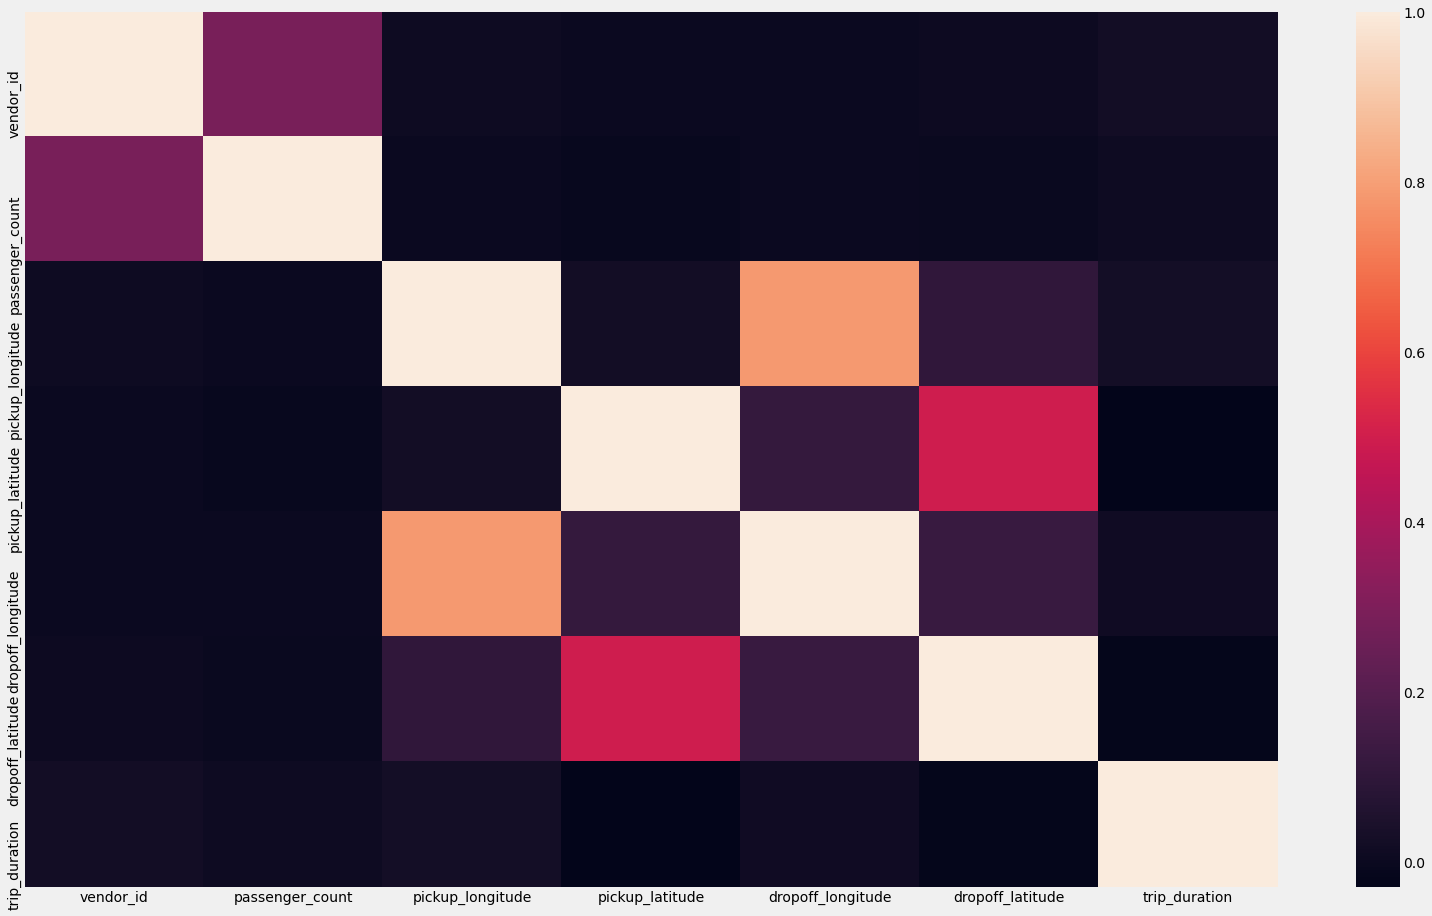

In [7]:
corr = df.corr()                                                                #plotting co-relation chart
plt.figure(figsize=(25,15))
sns.heatmap(corr, annot=False)
plt.show()                                                                      #there is no correlation whatsoever between our dependent and independent variables, thus i will be making various features to improve this situation                                            

In [8]:
df.describe()                                                                   #their are few cases with passanger count 0, lets explore it
                                                                                #also minimum drip duretion is 1 sec which show an anomaly, lets remove them first
                                                                                # Minimum pickup and dropoff longitude are really low than mean

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [9]:
df=df[df.passenger_count!=0]                                                                              #Removing rows with 0 passenger count                                      

In [10]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')                 #Converting these dates to datetime format
df['dropoff_datetime']=pd.to_datetime(df['dropoff_datetime'],format='%Y-%m-%d %H:%M:%S')
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [11]:
print(np.percentile(df.trip_duration,0.1),
np.percentile(df.trip_duration,0.5),
np.percentile(df.trip_duration,1.5),                                            #after this the value starts to get saturated thus anything below 107 sec is mostly a outlier, now lets look for maximum value as well
np.percentile(df.trip_duration,2),
np.percentile(df.trip_duration,2.5),
np.percentile(df.trip_duration,3),
np.percentile(df.trip_duration,3.5))

7.0 51.0 107.0 122.0 135.0 146.0 156.0


In [12]:
print(np.percentile(df.trip_duration,98.5),
np.percentile(df.trip_duration,99),
np.percentile(df.trip_duration,99.5),                                           #after this the value starts to get increase suddenly thus anything above 4139 sec is mostly a outlier, lets remove these values
np.percentile(df.trip_duration,99.9))

3072.0 3440.0 4139.0 85127.41700000013


In [13]:
df=df[(df.trip_duration>=107) & (df.trip_duration<=4139)]

In [14]:
print(np.percentile(df.pickup_longitude,0.1),
      np.percentile(df.pickup_longitude,0.05),                                  #after this their is anomaly 
      np.percentile(df.pickup_longitude,0.01),                                                                  
      np.percentile(df.pickup_longitude,0.001),
      np.percentile(df.pickup_longitude,0.0001))
df=df[df.pickup_longitude>-74.017]
print(np.percentile(df.dropoff_longitude,0.1),
      np.percentile(df.dropoff_longitude,0.05),
      np.percentile(df.dropoff_longitude,0.01),                                 #after this their is anomaly                                 
      np.percentile(df.dropoff_longitude,0.001),
      np.percentile(df.dropoff_longitude,0.0001))
df=df[df.dropoff_longitude>=-74.467]

-74.01712036132812 -74.01737976074219 -74.07968558120727 -74.35324770942688 -103.73459467295076
-74.17746734619139 -74.18138921356203 -74.18852077331543 -74.46795725708009 -79.53859309568787


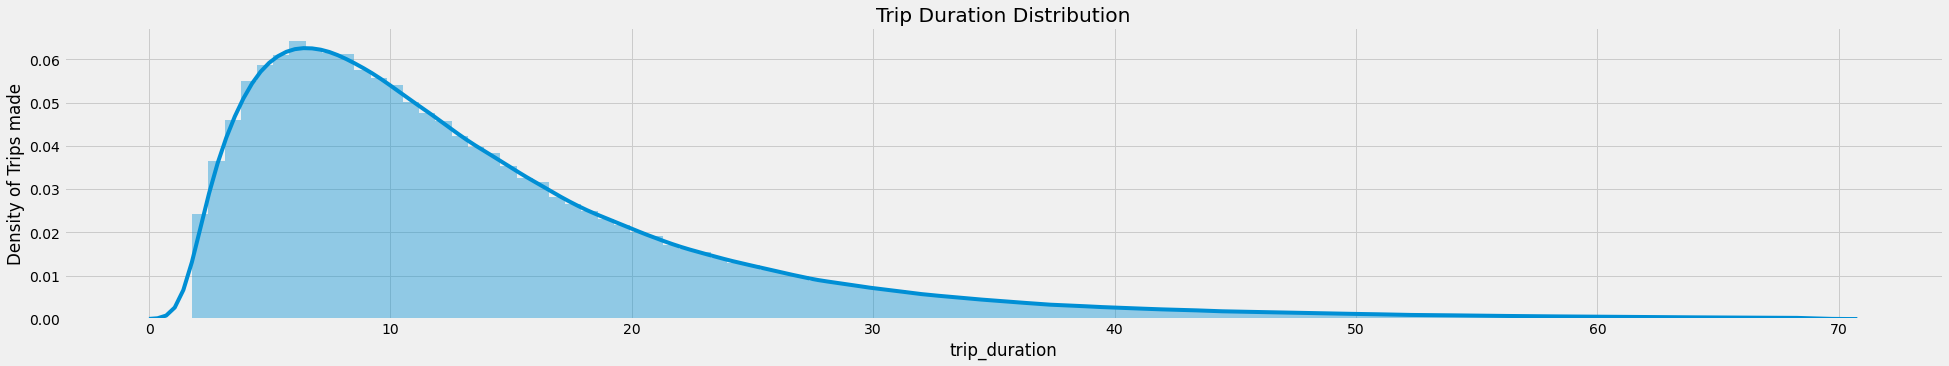

In [15]:
plt.figure(figsize=(30,5))
plt.title('Trip Duration Distribution')
plt.xlabel('Trip Duration, minutes')
plt.ylabel('Density of Trips made')
sns.distplot(df.trip_duration/60, bins=100)

In [16]:
#adding another column with distance metric calculted using lat and long 
df['haversine distance (km)'] = df.apply(lambda x: float(hs.haversine((x['pickup_latitude'],x['pickup_longitude']),(x['dropoff_latitude'], x['dropoff_longitude']))),axis=1)
df.shape

(1427892, 12)

In [17]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df.describe()                                                                   #Data looks Perfect now,still their can be some relative anomalies, which i will remove using isolation forest                      

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,haversine distance (km)
count,1427892.000,1427892.000,1427892.000,1427892.000,1427892.000,1427892.000,1427892.000,1427892.000
mean,1.535,1.666,-73.974,40.751,-73.974,40.752,833.573,3.428
std,0.499,1.315,0.041,0.031,0.039,0.034,607.683,4.004
min,1.000,1.000,-74.017,34.360,-74.455,34.360,107.000,0.000
25%,1.000,1.000,-73.992,40.738,-73.991,40.736,407.000,1.262
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,668.000,2.118
75%,2.000,2.000,-73.968,40.768,-73.963,40.770,1075.000,3.887
max,2.000,9.000,-61.336,51.881,-61.336,43.912,4139.000,1240.910


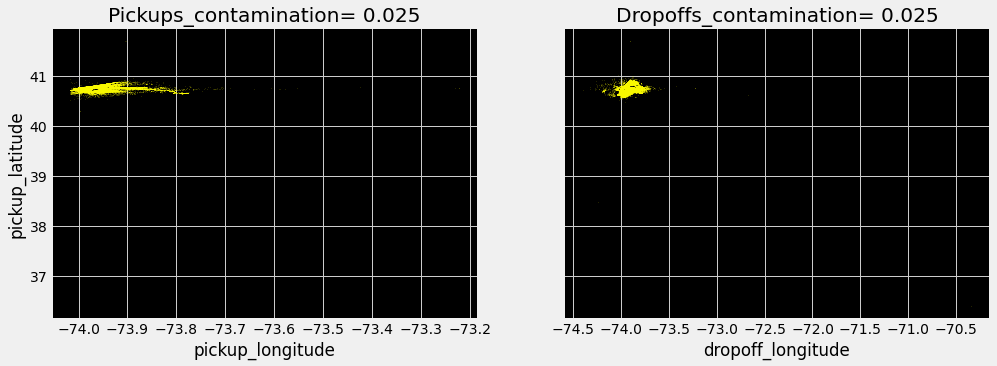

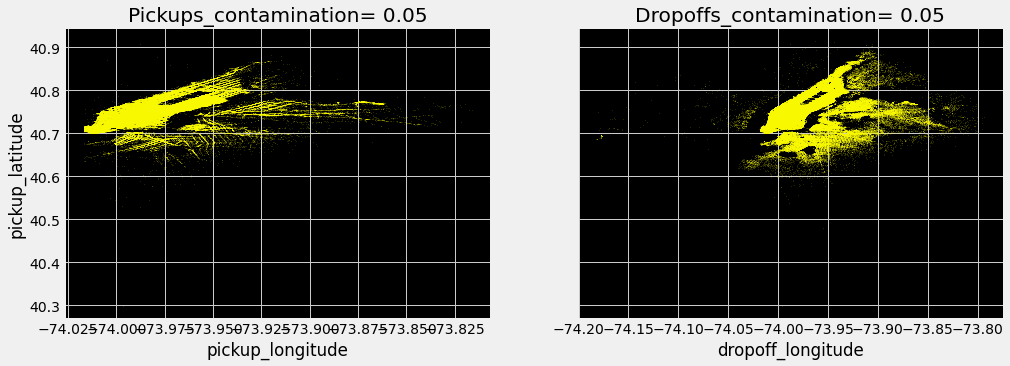

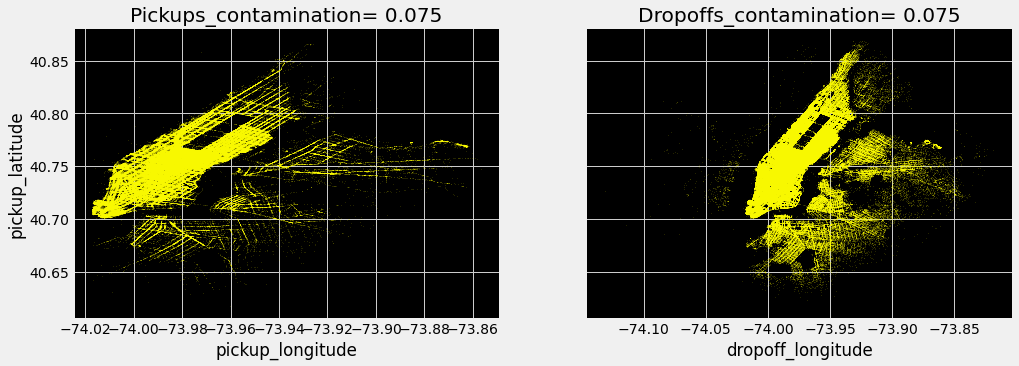

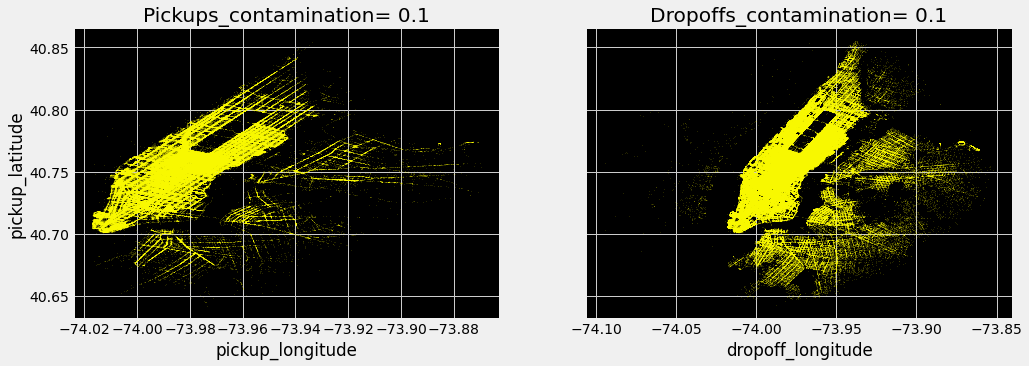

In [18]:
minmax = MinMaxScaler(feature_range=(0, 1))                                     #Using Isolation Forest algorithm for anomaly detection, for contamination i will use various values and visualize the best scatter plot
X = minmax.fit_transform(df[['trip_duration','haversine distance (km)','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']])
contamination_list=[0.025,0.05,0.075,0.1]
for contamination in contamination_list:
  clf = IsolationForest(n_estimators=100, contamination=contamination, random_state=0)      
  try:
    clf.fit(X)
  except:
    pass
  temp=df
  temp['multivariate_outlier'] = clf.predict(X)                                 # prediction of a datapoint category outlier or inlier
  temp=temp[temp.multivariate_outlier==1]                                             #removing these outliers
  f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,5))

  temp.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',
                  color='yellow', 
                  s=.02, alpha=.6, subplots=True, ax=ax1)
  ax1.set_title(f"Pickups_contamination= {contamination}")
  ax1.set_facecolor('black')

  temp.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude',
                  color='yellow', 
                  s=.02, alpha=.6, subplots=True, ax=ax2)
  ax2.set_title(f"Dropoffs_contamination= {contamination}")
  ax2.set_facecolor('black') 
  plt.show()

In [19]:
'''Thus contamination=0.075 works best as we want to retain maximum amount of data'''
minmax = MinMaxScaler(feature_range=(0, 1))                                     #Using Isolation Forest algorithm for anomaly detection, for contamination i will use various values and visualize the best scatter plot
X = minmax.fit_transform(df[['trip_duration','haversine distance (km)',
                             'pickup_longitude','pickup_latitude',
                             'dropoff_longitude','dropoff_latitude']])
clf = IsolationForest(n_estimators=100, contamination=0.075, random_state=0)      
clf.fit(X)
df['multivariate_outlier'] = clf.predict(X)                                     # prediction of a datapoint category outlier or inlier
df=df[df.multivariate_outlier==1]  
df.drop('multivariate_outlier',axis=1,inplace=True)

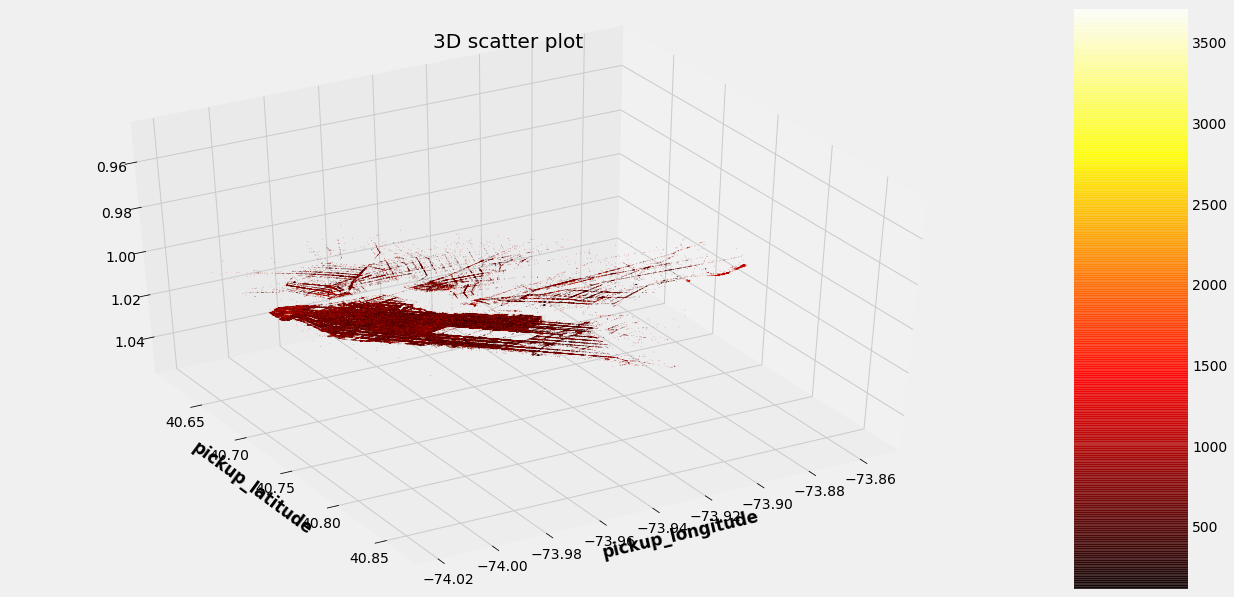

In [20]:
def plot_scatter(df):                                                           # Plotting 3D Scatter Plot        
  fig = plt.figure(figsize = (20, 10))
  ax = plt.axes(projection ="3d")
  # Creating color map
  z=range(1,len(df['pickup_longitude'])+1)
  Z=[]
  count=0
  my_cmap = plt.get_cmap('hot')
  plot=ax.scatter3D(df['pickup_longitude'],df['pickup_latitude'],
                    1,cmap = my_cmap,alpha = 0.8,
                    c =df['trip_duration'],s=0.02)                              # C is trip duration, thus colors here represent the duration of the trip
  plt.title("3D scatter plot")
  ax.set_xlabel('pickup_longitude', fontweight ='bold')
  ax.set_ylabel('pickup_latitude', fontweight ='bold')
  fig.colorbar(plot, ax = ax, aspect = 5)
  ax.view_init(-140, -60)
  plt.show()       
                                                                              
plot_scatter(df)                                                                

In [21]:
import folium
from folium import plugins
from folium.plugins import HeatMap

map_NY = folium.Map(location=[40.767937,-73.982155 ],
                    zoom_start = 13) 
heat_df = df[:20000]
heat_df = heat_df[['pickup_latitude', 'pickup_longitude']]
heat_df = heat_df.dropna(axis=0, subset=['pickup_latitude', 'pickup_longitude'])
heat_data = [[row['pickup_latitude'],row['pickup_longitude']] for index, row in heat_df.iterrows()] # List comprehension to make out list of lists

HeatMap(heat_data).add_to(map_NY)                                                                    # Plot it on the map

map_NY

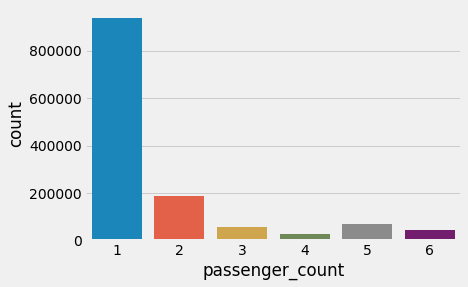

In [23]:
try:
  df.drop('id',axis=1,inplace=True)                                             # this is of no use, thus droping it
except:
  pass
sns.countplot(df.passenger_count)

In [24]:
''' I tried using One hot encoding to improve my model, but no improvemt actually took place '''
# one_hot_entity='Passenger_count'    
# column_one_hot=['passenger_count']                                            # one hot encoding 
# count=0
# for i in column_one_hot:
#   temp_df=pd.get_dummies(df[i], prefix=one_hot_entity)
#   count+=1
#   try:
#     df_one_hot=pd.concat([df_one_hot, temp_df], axis=1)
#   except:
#     df_one_hot=temp_df
# df=pd.concat([df,df_one_hot], axis=1)
# df.drop('passenger_count',axis=1,inplace=True)
# df.head()

In [25]:
list=['pickup_','dropoff_']                                                     # Creating new features
for i in list:  
  df[i+'date'] = df[i+'datetime'].dt.date
  df[i+'day'] = df[i+'datetime'].dt.day
  df[i+'month'] = df[i+'datetime'].dt.month
  df[i+'weekday'] = df[i+'datetime'].dt.weekday
  df[i+'weekofyear'] = df[i+'datetime'].dt.weekofyear
  df[i+'time'] = df[i+'datetime'].dt.hour

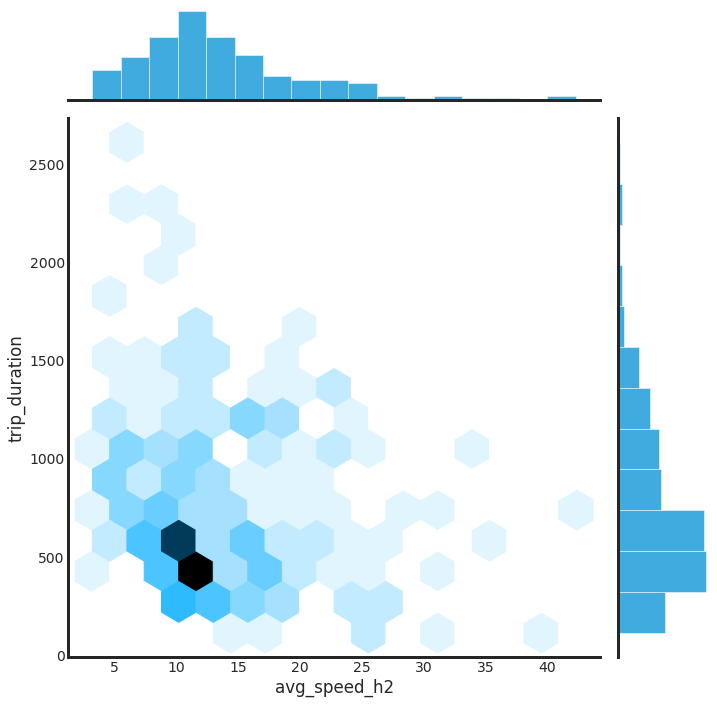

In [26]:
df['avg_speed_h2']=df['haversine distance (km)']*3600  / df['trip_duration']    #converting sec to hours
with sns.axes_style('white'):
    sns.jointplot('avg_speed_h2', "trip_duration", df[:200], kind='hex',height=10)    
avg_speed_vs_hr=df.groupby('pickup_time')['avg_speed_h2'].mean()
avg_speed_vs_week=df.groupby('pickup_weekday')['avg_speed_h2'].mean()
avg_speed_vs_weekofyear=df.groupby('pickup_weekofyear')['avg_speed_h2'].mean()
avg_speed_vs_month=df.groupby('pickup_month')['avg_speed_h2'].mean()
avg_speed_vs_day=df.groupby('pickup_day')['avg_speed_h2'].mean()
avg_speed_vs_date=df.groupby('pickup_date')['avg_speed_h2'].mean()
dict_hr=dict(zip(avg_speed_vs_hr.index,avg_speed_vs_hr.values))
dict_week=dict(zip(avg_speed_vs_week.index,avg_speed_vs_week.values))
dict_weekofyear=dict(zip(avg_speed_vs_weekofyear.index,avg_speed_vs_weekofyear.values))
dict_month=dict(zip(avg_speed_vs_month.index,avg_speed_vs_month.values))
dict_day=dict(zip(avg_speed_vs_day.index,avg_speed_vs_day.values))

In [27]:
df['avg_speed_hr']=df['pickup_time'].apply(lambda x:dict_hr[x])                            #now we can put this value in our model, and it will not create a baise.
df['avg_speed_hr']=np.log(df['avg_speed_hr'])
df['avg_speed_week']=df['pickup_weekday'].apply(lambda x:dict_week[x])                     #now we can put this value in our model, and it will not create a baise.
df['avg_speed_week']=np.log(df['avg_speed_week'])
df['avg_speed_weekofyear']=df['pickup_weekofyear'].apply(lambda x:dict_weekofyear[x])      #now we can put this value in our model, and it will not create a baise.
df['avg_speed_weekofyear']=np.log(df['avg_speed_weekofyear'])
df['avg_speed_month']=df['pickup_month'].apply(lambda x:dict_month[x])                     #now we can put this value in our model, and it will not create a baise.
df['avg_speed_month']=np.log(df['avg_speed_month'])
df['avg_speed_day']=df['pickup_day'].apply(lambda x:dict_day[x])                           #now we can put this value in our model, and it will not create a baise.
df['avg_speed_day']=np.log(df['avg_speed_day'])

In [28]:
df['log_trip_duration']= np.log(df.trip_duration)                               #Normalizing the value of trip_duration
df['haversine distance (km)']= np.log(df['haversine distance (km)']) 
df['store_and_fwd_flag']=df.store_and_fwd_flag.apply(lambda x: np.where(x=='N',0,1))
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,haversine distance (km),pickup_date,pickup_day,pickup_month,pickup_weekday,pickup_weekofyear,pickup_time,dropoff_date,dropoff_day,dropoff_month,dropoff_weekday,dropoff_weekofyear,dropoff_time,avg_speed_h2,avg_speed_hr,avg_speed_week,avg_speed_weekofyear,avg_speed_month,avg_speed_day,log_trip_duration
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,0,455,0.404,2016-03-14,14,3,0,11,17,2016-03-14,14,3,0,11,17,11.856,2.469,2.639,2.606,2.616,2.591,6.120
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,0,663,0.591,2016-06-12,12,6,6,23,0,2016-06-12,12,6,6,23,0,9.804,2.800,2.748,2.569,2.580,2.588,6.497
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,0,2124,1.854,2016-01-19,19,1,1,3,11,2016-01-19,19,1,1,3,12,10.822,2.452,2.552,2.593,2.625,2.602,7.661
3,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,0,429,0.396,2016-04-06,6,4,2,14,19,2016-04-06,6,4,2,14,19,12.466,2.551,2.538,2.585,2.591,2.611,6.061
4,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,0,435,0.173,2016-03-26,26,3,5,12,13,2016-03-26,26,3,5,12,13,9.837,2.445,2.648,2.641,2.616,2.583,6.075


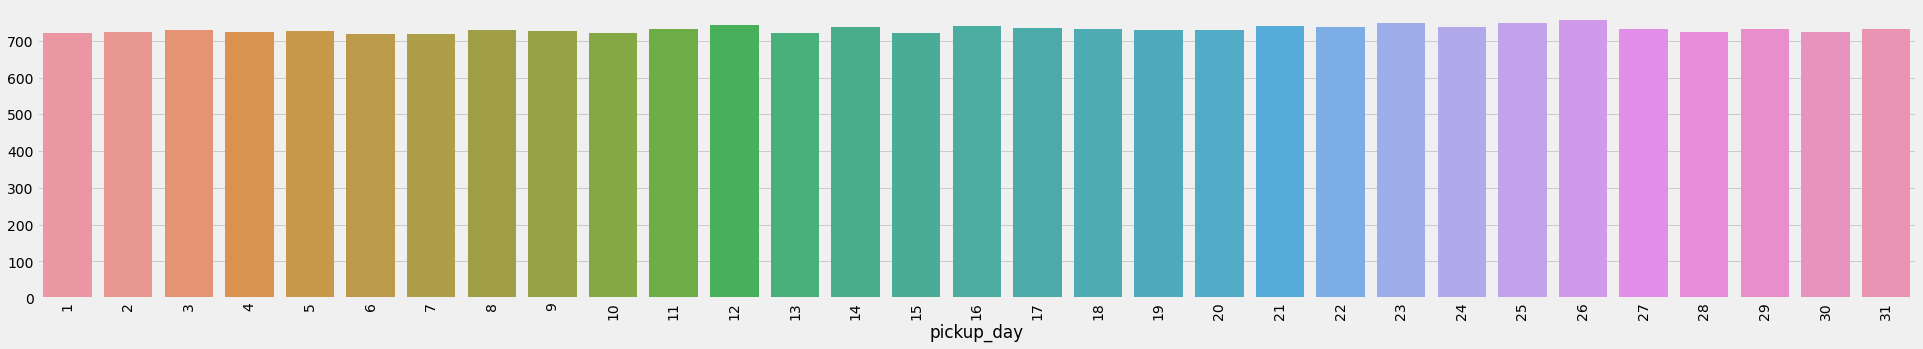

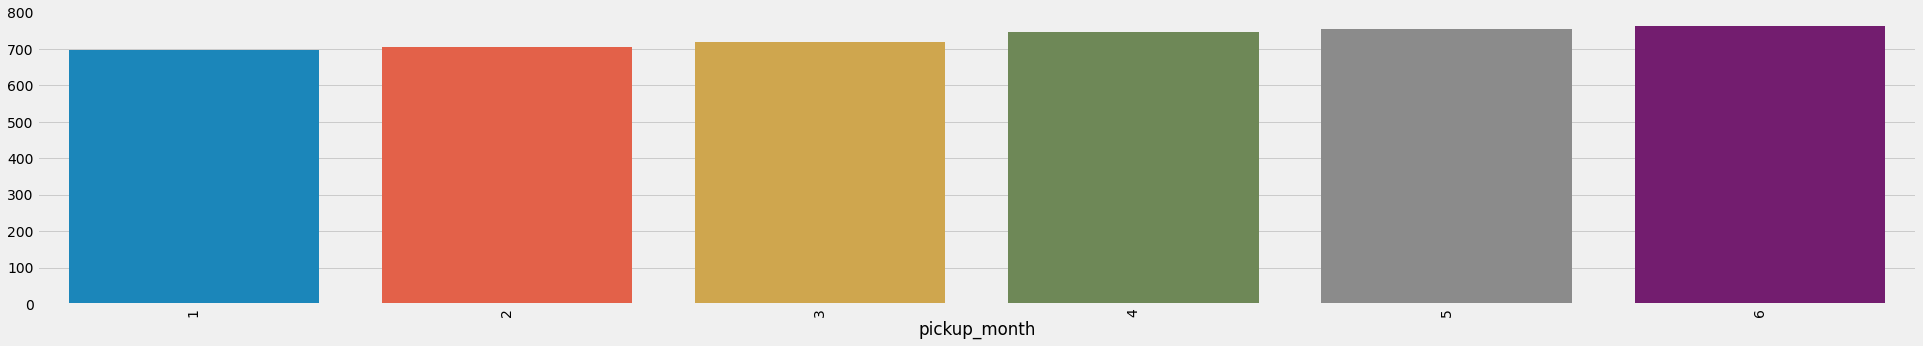

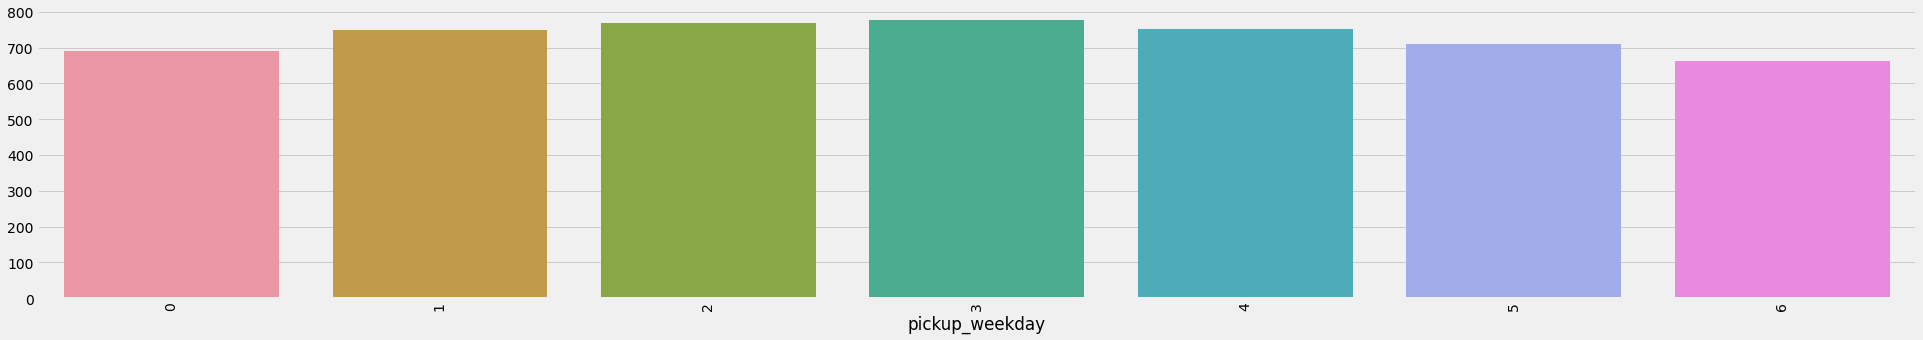

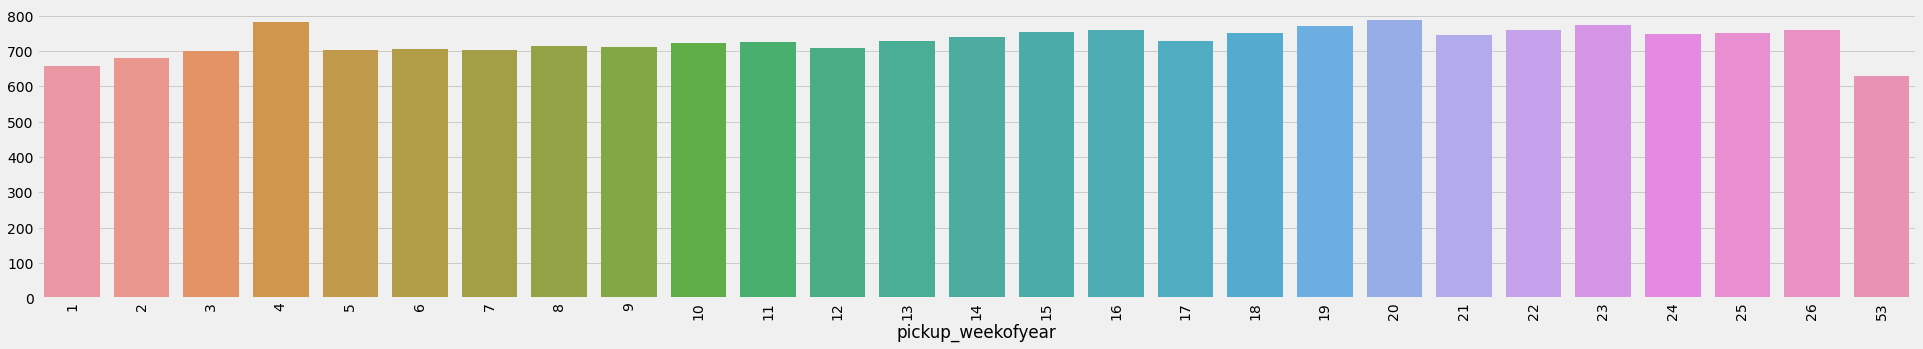

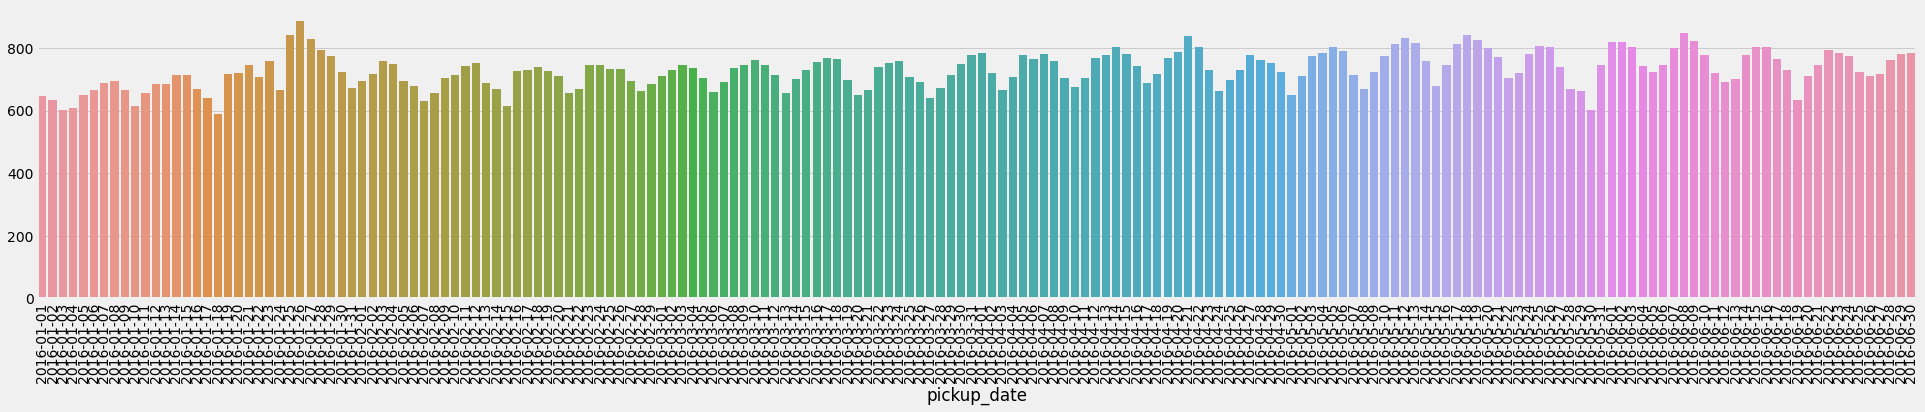

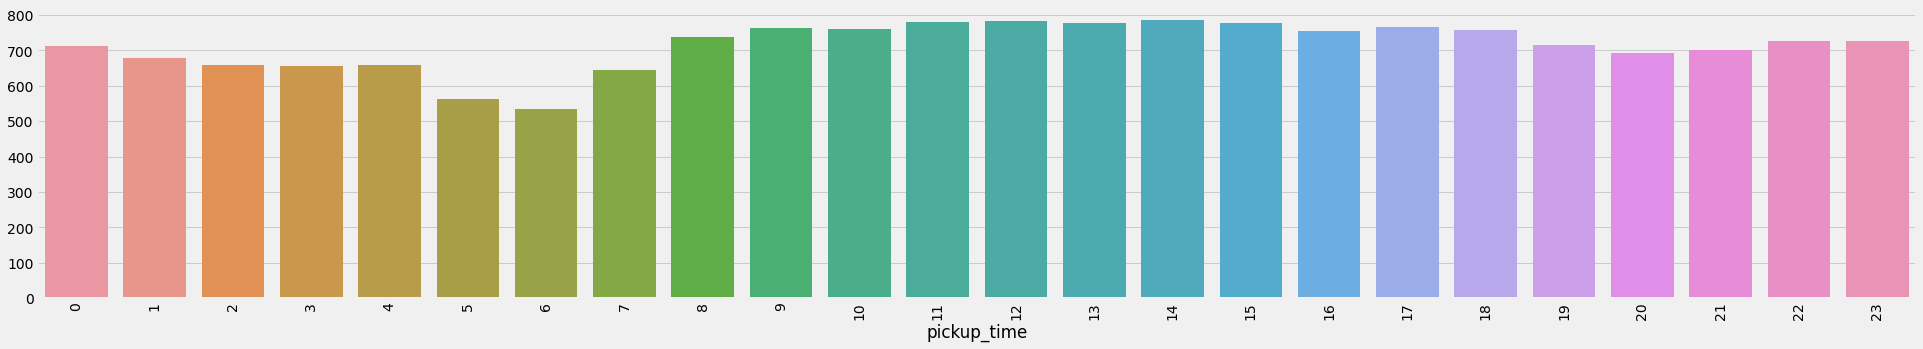

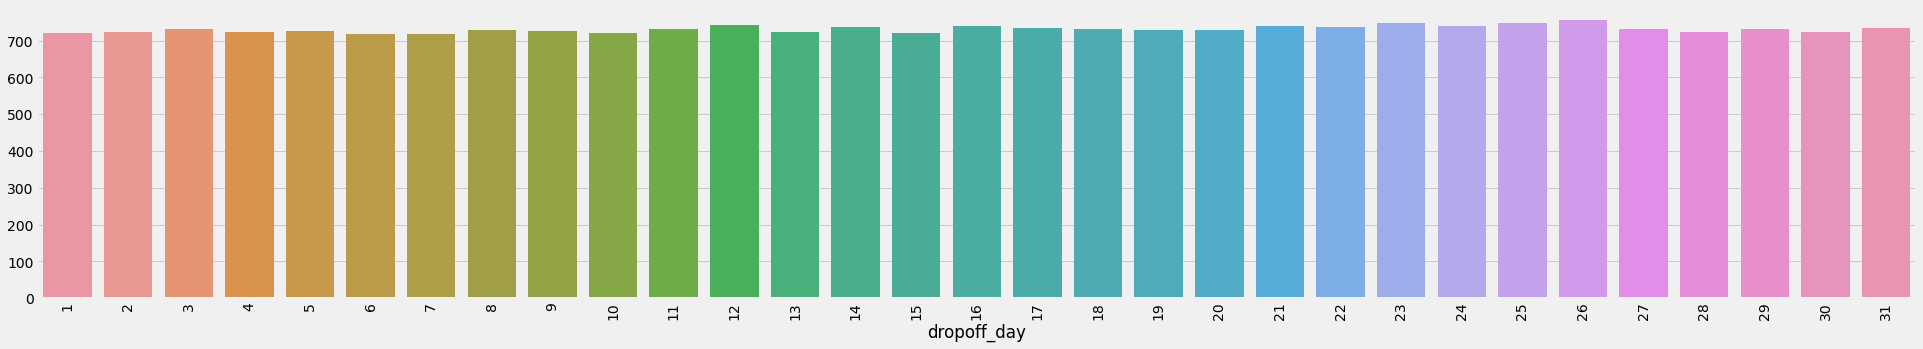

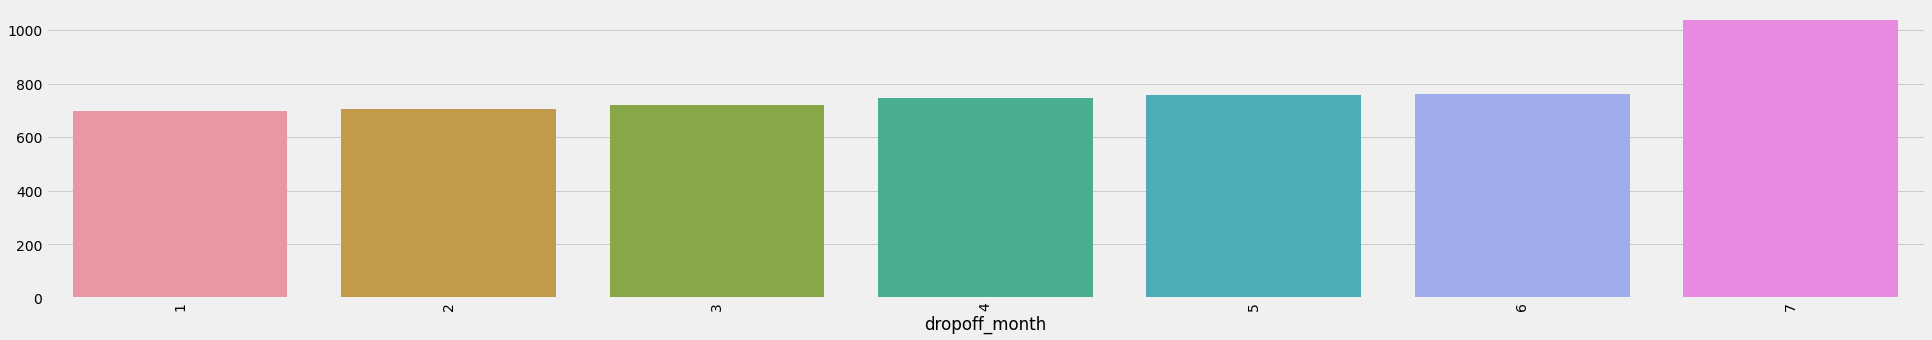

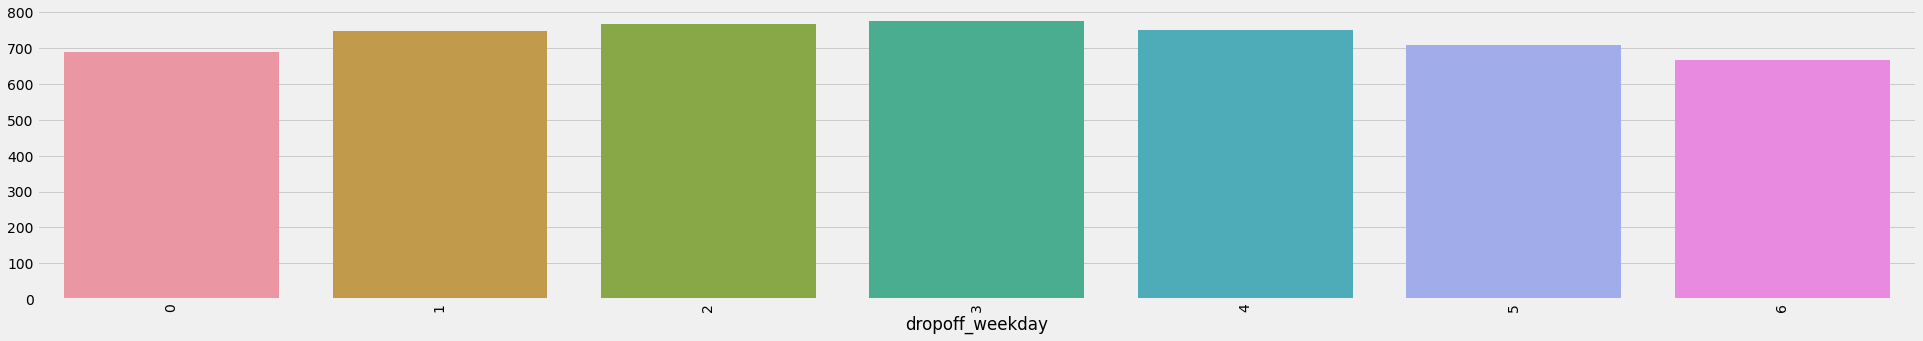

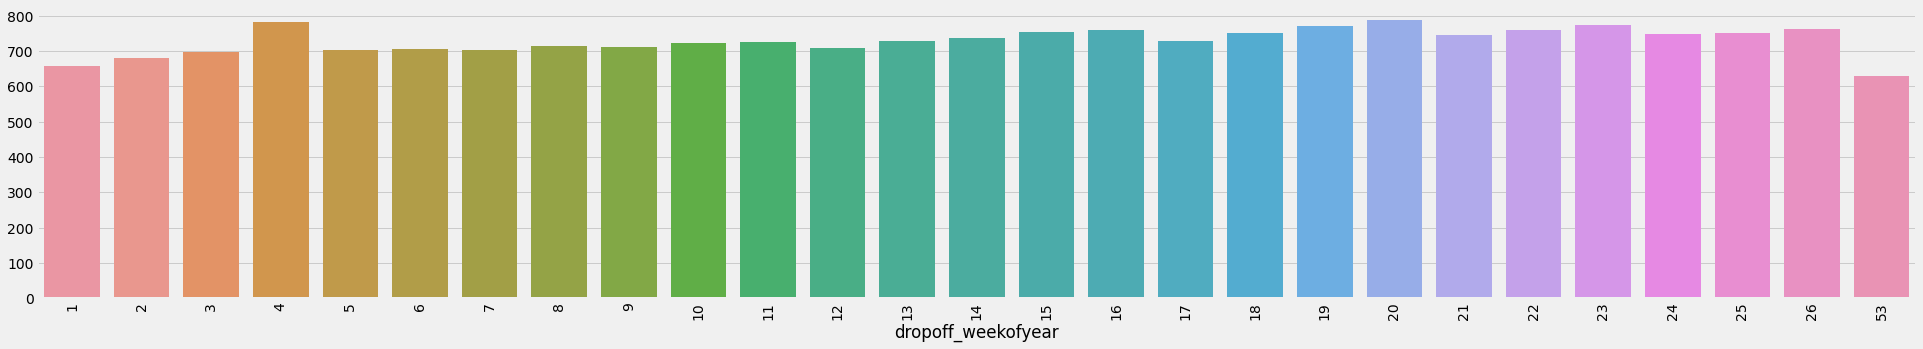

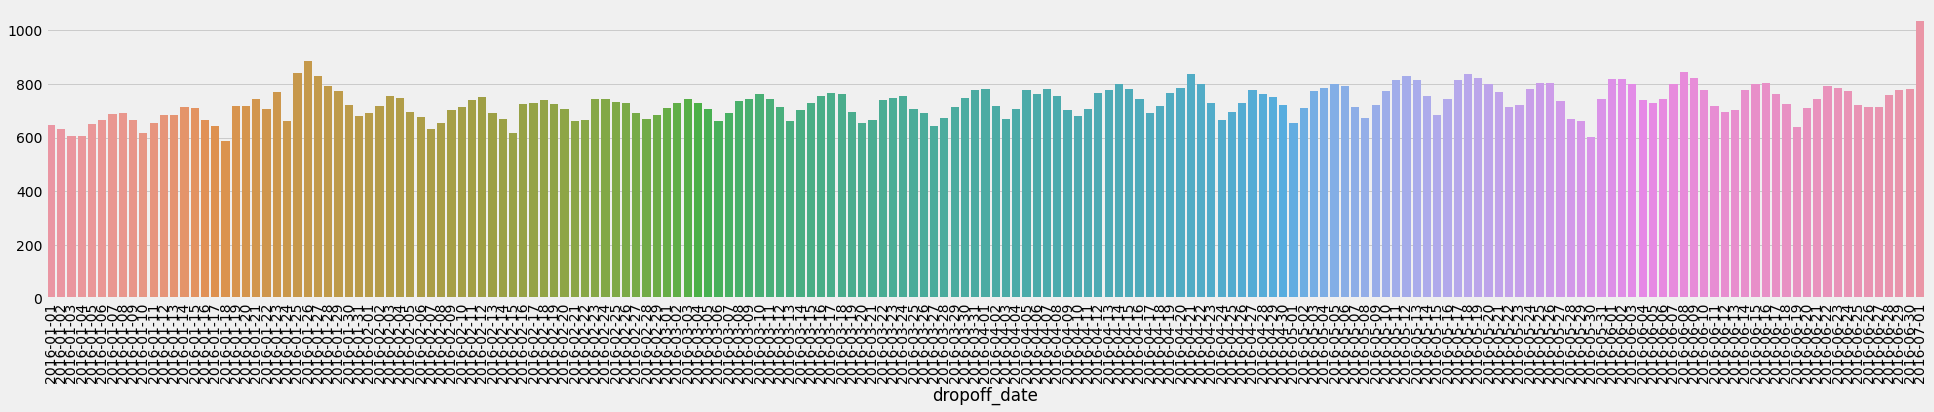

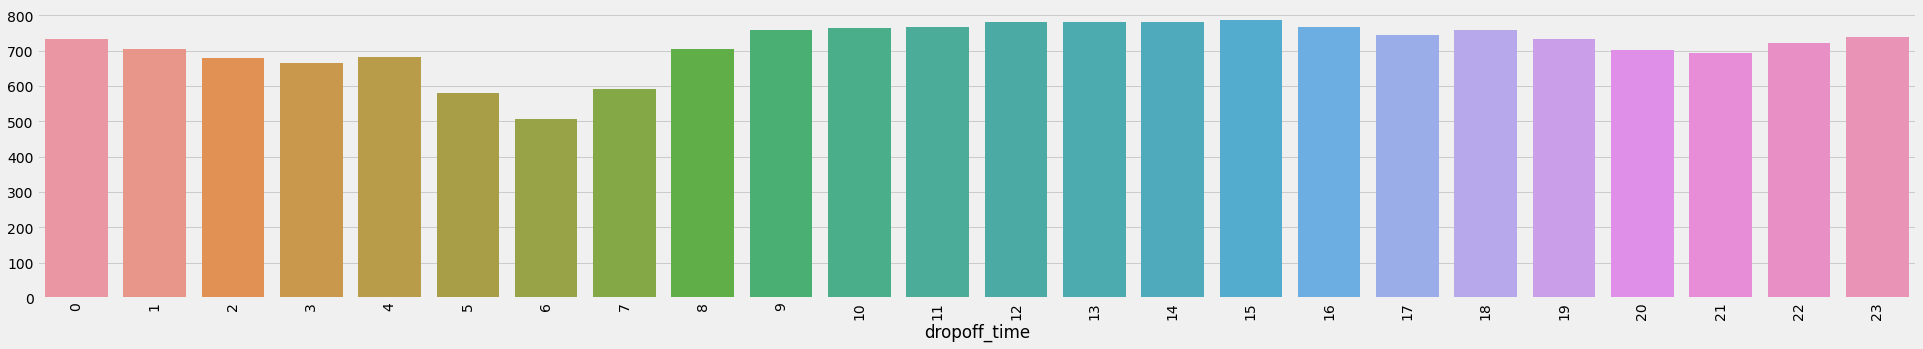

In [29]:
list1=['day','month','weekday','weekofyear','date','time']
list2=['pickup_','dropoff_']
for i in list2:
  for j in list1:
    plt.figure(figsize=(30,5))
    temp=df.groupby(i+j)['trip_duration'].mean()
    sns.barplot(temp.index,temp.values)
    plt.xticks(rotation=90)
    plt.show()                                                                  # for all the time criteria trip durations are almost the same, except that of hours in a day, lets plot autocorelation chart to look for seasonality.

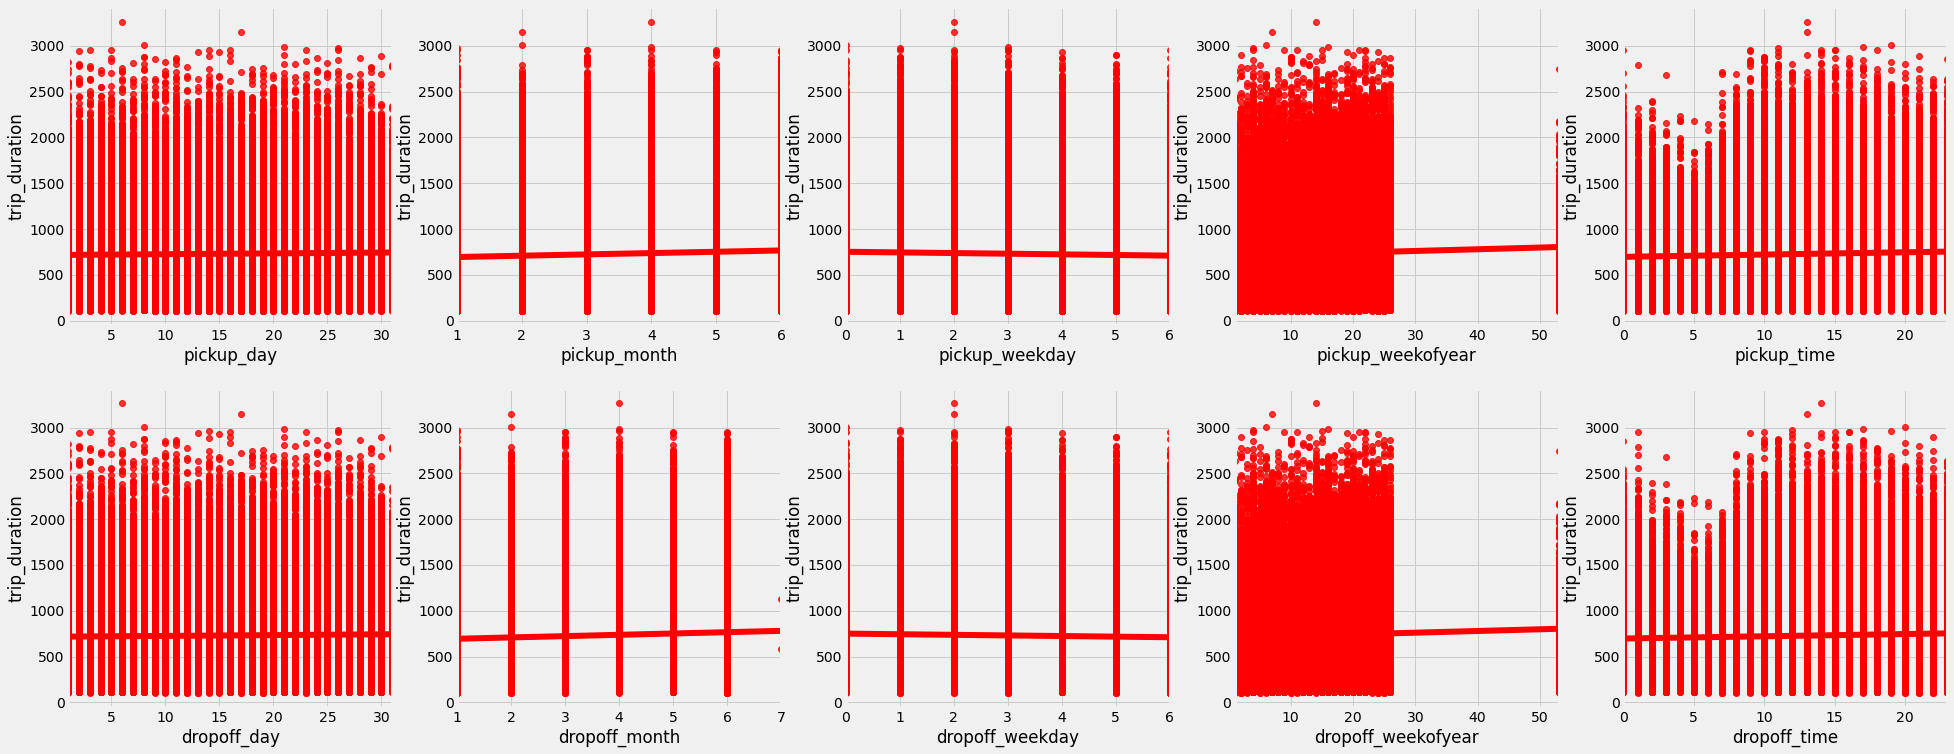

In [30]:
time_attribute=['day','month','weekday','weekofyear','time']                    # Plotting Reg Plot
service_nature=['pickup_','dropoff_']
count=0
counter=0
fig,ax=plt.subplots(2,5,figsize=(30,12))
plt.rcParams['axes.facecolor'] = 'black'
for service in service_nature:
  if counter==5:
    count=1
    counter=0
  for attribute in time_attribute:
    sns.regplot(df[service+attribute][:100000],df.trip_duration[:100000],color='red',ax=ax[count,counter])
    
    counter+=1                                                                  # Reg plot shows the linear relationship between trip duration and all the time formats.                                        

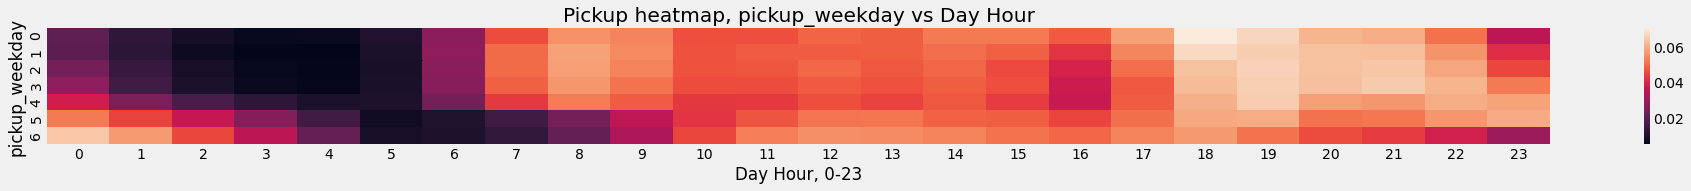

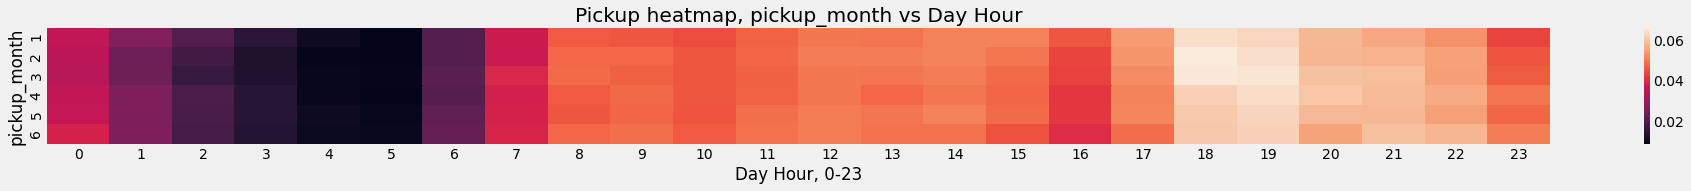

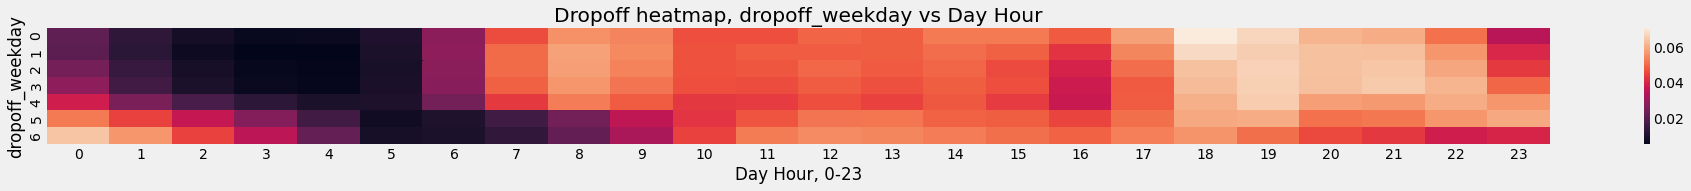

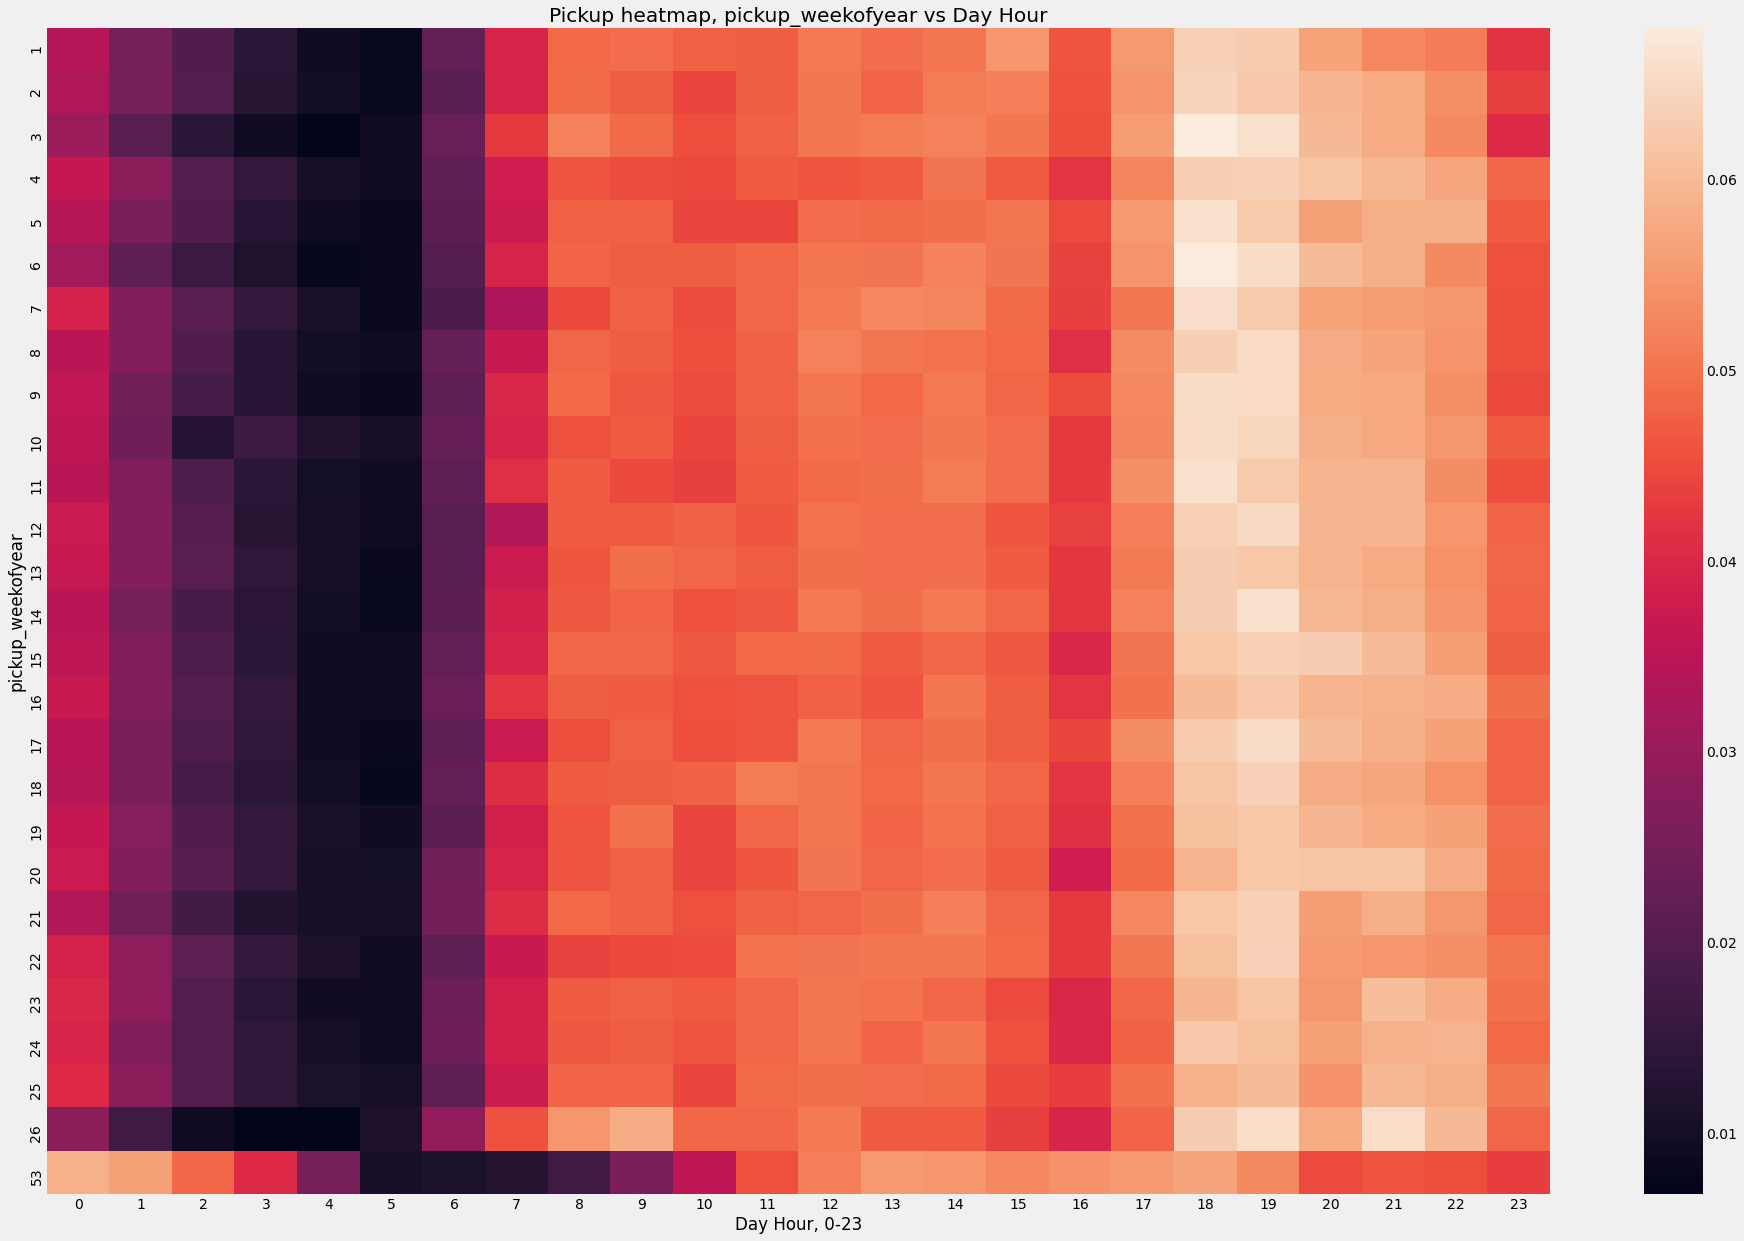

In [31]:
plot_list=['pickup_weekday','pickup_month','dropoff_weekday','pickup_weekofyear']
count=0
for i in plot_list:
  count+=1
  if count==4:
    plt.figure(figsize=(30,20))
  else:
    plt.figure(figsize=(30,2))
  sns.heatmap(data=pd.crosstab(df[i], 
                              df.pickup_time, 
                              values=df.vendor_id, 
                              aggfunc='count',
                              normalize='index'))
  if count==3:
    plt.title(f'Dropoff heatmap, {i} vs Day Hour')
    plt.ylabel(i) ; plt.xlabel('Day Hour, 0-23')
    
    plt.show()
  else:
    plt.title(f'Pickup heatmap, {i} vs Day Hour')
    plt.ylabel(i) ; plt.xlabel('Day Hour, 0-23')
    
    
    plt.show()                                                                  #Both heat maps tells the similar story, 6-7pm are the peak times, and nights hardly have any bookings.

In [32]:
df.drop(['avg_speed_h2'],axis=1,inplace=True)

In [33]:
df.drop(['pickup_datetime','dropoff_datetime','trip_duration','pickup_date','dropoff_date','dropoff_day','dropoff_month','dropoff_weekday','dropoff_weekofyear','dropoff_time'],axis=1,inplace=True)

In [34]:
df['lat_diff']=df.dropoff_latitude-df.pickup_latitude
df['long_diff']=df.dropoff_longitude-df.pickup_longitude                        # west yeild -ve on long_diff, vice versa & north yeild + lat_diff and vice versa, thus we can now give directions.
# df.drop(['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis=1,inplace=True)

In [35]:
df['North']=df['lat_diff'].apply(lambda x: np.where(x>0,1,0))
df['South']=df['lat_diff'].apply(lambda x: np.where(x<0,1,0))
df['West']=df['long_diff'].apply(lambda x: np.where(x<0,1,0))
df['East']=df['long_diff'].apply(lambda x: np.where(x>0,1,0))

df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,haversine distance (km),pickup_day,pickup_month,pickup_weekday,pickup_weekofyear,pickup_time,avg_speed_hr,avg_speed_week,avg_speed_weekofyear,avg_speed_month,avg_speed_day,log_trip_duration,lat_diff,long_diff,North,South,West,East
0,2,1,-73.982,40.768,-73.965,40.766,0,0.404,14,3,0,11,17,2.469,2.639,2.606,2.616,2.591,6.120,-0.002,0.018,0,1,0,1
1,1,1,-73.980,40.739,-73.999,40.731,0,0.591,12,6,6,23,0,2.800,2.748,2.569,2.580,2.588,6.497,-0.007,-0.019,0,1,1,0
2,2,1,-73.979,40.764,-74.005,40.710,0,1.854,19,1,1,3,11,2.452,2.552,2.593,2.625,2.602,7.661,-0.054,-0.026,0,1,1,0
3,2,1,-74.010,40.720,-74.012,40.707,0,0.396,6,4,2,14,19,2.551,2.538,2.585,2.591,2.611,6.061,-0.013,-0.002,0,1,1,0
4,2,1,-73.973,40.793,-73.973,40.783,0,0.173,26,3,5,12,13,2.445,2.648,2.641,2.616,2.583,6.075,-0.011,0.000,0,1,0,1


In [36]:
# column_one_hot=['pickup_time','pickup_weekofyear','pickup_weekday','pickup_month','pickup_day','vendor_id']                # one hot encoding 
# for i in column_one_hot:
#   temp2_df=pd.get_dummies(df[i], prefix=i)
#   try:
#     df_one_hot2=pd.concat([df_one_hot2, temp2_df], axis=1)
#   except:
#     df_one_hot2=temp2_df

In [37]:
# df=pd.concat([df,df_one_hot2], axis=1)
# df.drop(['pickup_time','pickup_weekofyear','pickup_weekday','pickup_month','pickup_day','vendor_id','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis=1,inplace=True)

In [38]:
df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,haversine distance (km),pickup_day,pickup_month,pickup_weekday,pickup_weekofyear,pickup_time,avg_speed_hr,avg_speed_week,avg_speed_weekofyear,avg_speed_month,avg_speed_day,log_trip_duration,lat_diff,long_diff,North,South,West,East
0,2,1,-73.982,40.768,-73.965,40.766,0,0.404,14,3,0,11,17,2.469,2.639,2.606,2.616,2.591,6.120,-0.002,0.018,0,1,0,1
1,1,1,-73.980,40.739,-73.999,40.731,0,0.591,12,6,6,23,0,2.800,2.748,2.569,2.580,2.588,6.497,-0.007,-0.019,0,1,1,0
2,2,1,-73.979,40.764,-74.005,40.710,0,1.854,19,1,1,3,11,2.452,2.552,2.593,2.625,2.602,7.661,-0.054,-0.026,0,1,1,0
3,2,1,-74.010,40.720,-74.012,40.707,0,0.396,6,4,2,14,19,2.551,2.538,2.585,2.591,2.611,6.061,-0.013,-0.002,0,1,1,0
4,2,1,-73.973,40.793,-73.973,40.783,0,0.173,26,3,5,12,13,2.445,2.648,2.641,2.616,2.583,6.075,-0.011,0.000,0,1,0,1


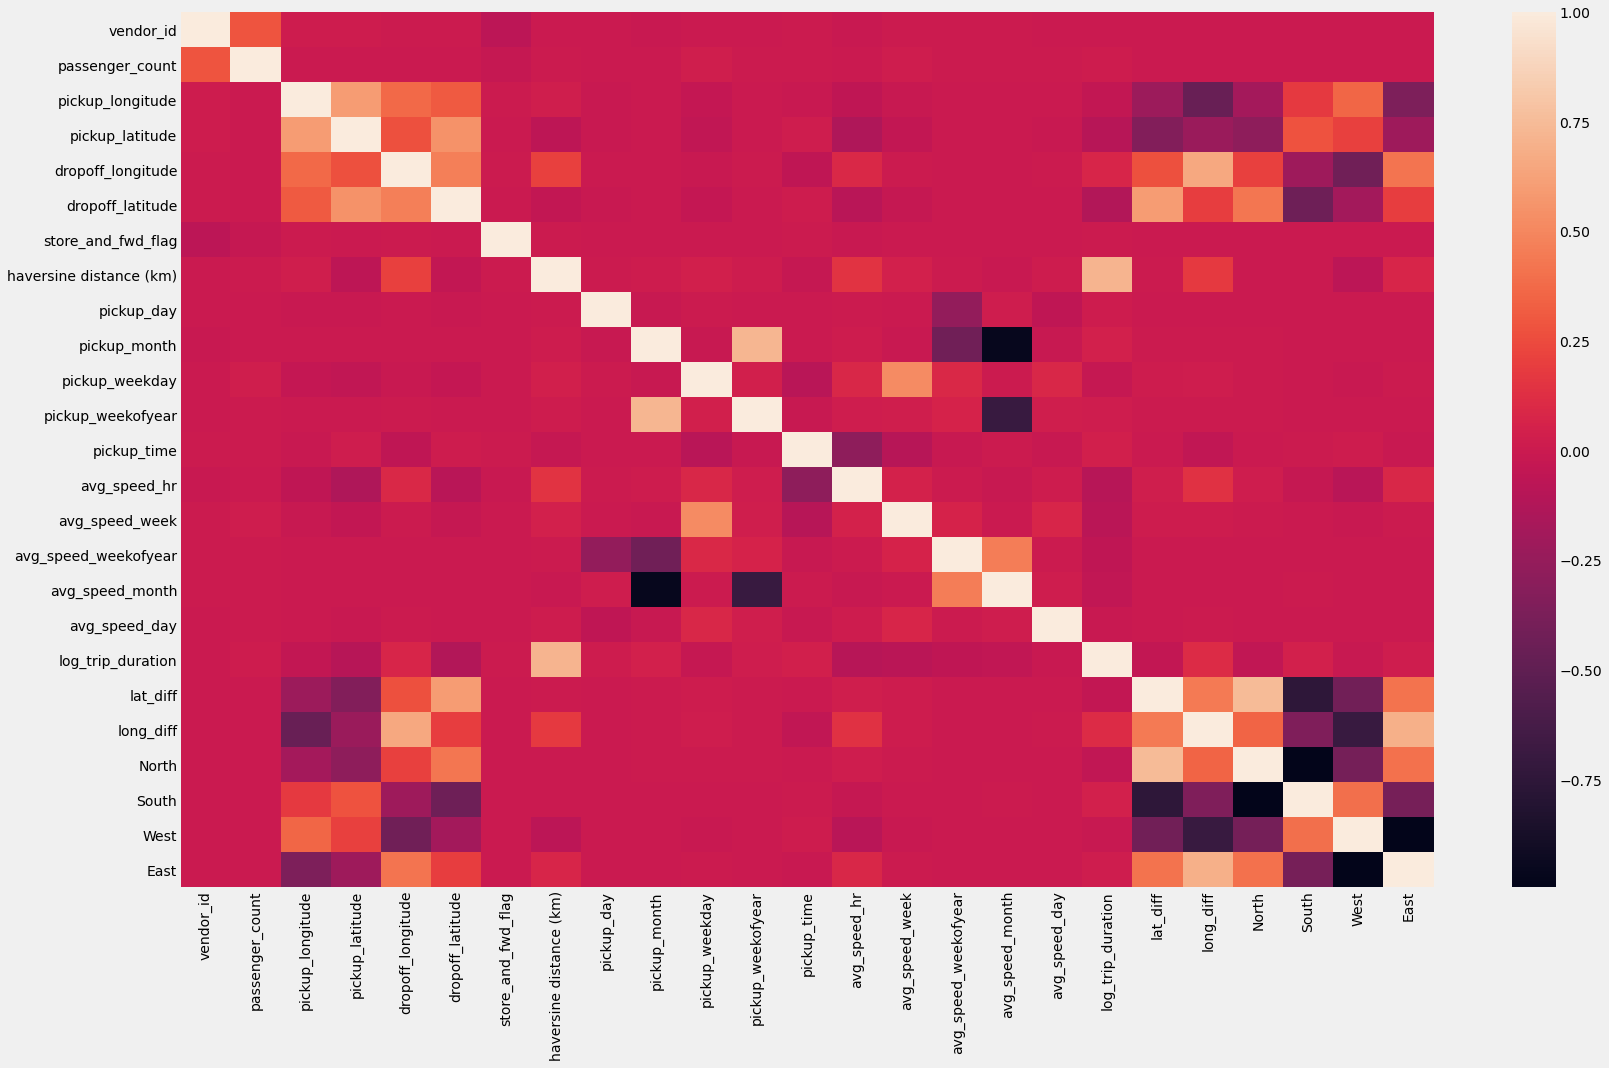

In [39]:
corr =df.corr()                                                                 #plotting co-relation chart
plt.figure(figsize=(25,15))
sns.heatmap(corr, annot=False)
plt.show()   

In [47]:
X=df.drop('log_trip_duration',axis=1)[:100000]                                  # using a smaller size for hyperparameter tuning, as dataset is quite large
y=df['log_trip_duration'][:100000]
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.05)
X_train, X_val, y_train, y_val= train_test_split(X_train,y_train,test_size=0.1)

#HyperParameter Tuning  for XGBoost and CatBoost Model

In [53]:
from sklearn.model_selection import GridSearchCV  
xgb_model = XGBRegressor()
learning_rate= [0.1,0.25,0.5]                                                   # various learning rates i will tryout
nax_depth = [10,12]      
n_estimators=[100,200,300]                                                      # various depths that i will try out
parameters = dict(learning_rate=learning_rate, nax_depth=nax_depth, n_estimators=n_estimators,objective=['reg:squarederror'])     
grid = GridSearchCV(xgb_model,parameters,scoring='r2', cv=None)                 # we can also use 'neg_mean_squared_error', here i am not using cv as dataset is quite large and well distributed.
grid_result=grid.fit(X_train, y_train)
print ("r2 / variance : ", grid.best_score_,'with parameter: ',grid_result.best_params_)
print("RMSE score: %.2f"
              % np.sqrt(metrics.mean_squared_error(y_test,grid.predict(X_test))))

r2 / variance :  0.7449471982256515 with parameter:  {'learning_rate': 0.25, 'n_estimators': 300, 'nax_depth': 10, 'objective': 'reg:squarederror'}
RMSE score: 0.32


As, Dataset is quite huge, using Kfold Cross-Validation and gridsearch was impossible due to hardware constraints, thus i decided to change values on by own by running model and looking at result multiple times.

In [54]:
from sklearn.model_selection import GridSearchCV  
cat_model = CatBoostRegressor()
learning_rate= [0.05,0.1,0.15]                                                  # various learning rates i will tryout
depth = [6,8,10]                                                                 # various depths that i will try out
parameters = dict(depth=depth,learning_rate=learning_rate,iterations=[1000],    # max iterations are set to 1000 
                  od_type=["Iter"],od_wait=[200],metric_period=[999],           # i have used overfitting detector & enables the use of best model
                  use_best_model = [True] )     
grid = GridSearchCV(cat_model,parameters,scoring='r2', cv=None)                 #we can also use 'neg_mean_squared_error', here i am not using cv as dataset is quite large and well distributed.
grid_result=grid.fit(X_train, y_train, eval_set=(X_val,y_val))
print ("r2 / variance : ", grid.best_score_,'with parameter: ',grid_result.best_params_)
print("RMSE score: %.2f"
              % np.sqrt(metrics.mean_squared_error(y_test,grid.predict(X_test))))

0:	learn: 0.6201754	test: 0.6193301	best: 0.6193301 (0)	total: 69.7ms	remaining: 1m 9s
999:	learn: 0.2949624	test: 0.3132886	best: 0.3132886 (999)	total: 10.9s	remaining: 0us

bestTest = 0.3132886227
bestIteration = 999

0:	learn: 0.6201591	test: 0.6193134	best: 0.6193134 (0)	total: 11.7ms	remaining: 11.7s


999:	learn: 0.2954270	test: 0.3129845	best: 0.3129845 (999)	total: 10.8s	remaining: 0us

bestTest = 0.3129845473
bestIteration = 999

0:	learn: 0.6209207	test: 0.6193055	best: 0.6193055 (0)	total: 12.1ms	remaining: 12.1s


999:	learn: 0.2953143	test: 0.3137859	best: 0.3137859 (999)	total: 11s	remaining: 0us

bestTest = 0.3137859336
bestIteration = 999

0:	learn: 0.6210959	test: 0.6192613	best: 0.6192613 (0)	total: 11.6ms	remaining: 11.6s


999:	learn: 0.2959205	test: 0.3125630	best: 0.3125630 (999)	total: 10.8s	remaining: 0us

bestTest = 0.3125629718
bestIteration = 999

0:	learn: 0.6204100	test: 0.6192826	best: 0.6192826 (0)	total: 11.3ms	remaining: 11.3s


999:	learn: 0.2937331	test: 0.3126375	best: 0.3126375 (999)	total: 10.8s	remaining: 0us

bestTest = 0.3126375299
bestIteration = 999

0:	learn: 0.6026836	test: 0.6017277	best: 0.6017277 (0)	total: 11.6ms	remaining: 11.6s


999:	learn: 0.2772668	test: 0.3102299	best: 0.3102140 (998)	total: 10.8s	remaining: 0us

bestTest = 0.310214
bestIteration = 998

Shrink model to first 999 iterations.
0:	learn: 0.6026658	test: 0.6017134	best: 0.6017134 (0)	total: 11.5ms	remaining: 11.5s


999:	learn: 0.2778103	test: 0.3095246	best: 0.3095103 (996)	total: 10.7s	remaining: 0us

bestTest = 0.3095103333
bestIteration = 996

Shrink model to first 997 iterations.
0:	learn: 0.6033447	test: 0.6016704	best: 0.6016704 (0)	total: 11.9ms	remaining: 11.9s


999:	learn: 0.2772898	test: 0.3111818	best: 0.3111569 (994)	total: 10.7s	remaining: 0us

bestTest = 0.311156898
bestIteration = 994

Shrink model to first 995 iterations.
0:	learn: 0.6034943	test: 0.6015927	best: 0.6015927 (0)	total: 12.7ms	remaining: 12.7s


999:	learn: 0.2780657	test: 0.3093186	best: 0.3093004 (998)	total: 10.8s	remaining: 0us

bestTest = 0.3093003566
bestIteration = 998

Shrink model to first 999 iterations.
0:	learn: 0.6028550	test: 0.6016464	best: 0.6016464 (0)	total: 11.5ms	remaining: 11.5s


999:	learn: 0.2760909	test: 0.3094996	best: 0.3094931 (994)	total: 10.7s	remaining: 0us

bestTest = 0.3094931314
bestIteration = 994

Shrink model to first 995 iterations.
0:	learn: 0.5856546	test: 0.5845868	best: 0.5845868 (0)	total: 11.9ms	remaining: 11.9s


999:	learn: 0.2646344	test: 0.3100093	best: 0.3099346 (958)	total: 10.8s	remaining: 0us

bestTest = 0.3099345977
bestIteration = 958

Shrink model to first 959 iterations.
0:	learn: 0.5856352	test: 0.5845747	best: 0.5845747 (0)	total: 11.7ms	remaining: 11.6s


999:	learn: 0.2652262	test: 0.3095046	best: 0.3093355 (978)	total: 10.8s	remaining: 0us

bestTest = 0.3093354618
bestIteration = 978

Shrink model to first 979 iterations.
0:	learn: 0.5862319	test: 0.5844980	best: 0.5844980 (0)	total: 11.9ms	remaining: 11.9s


999:	learn: 0.2654610	test: 0.3101837	best: 0.3101837 (999)	total: 10.8s	remaining: 0us

bestTest = 0.3101836952
bestIteration = 999

0:	learn: 0.5863561	test: 0.5843812	best: 0.5843812 (0)	total: 11.5ms	remaining: 11.5s


999:	learn: 0.2651617	test: 0.3084502	best: 0.3083782 (990)	total: 10.7s	remaining: 0us

bestTest = 0.3083781996
bestIteration = 990

Shrink model to first 991 iterations.
0:	learn: 0.5857628	test: 0.5844724	best: 0.5844724 (0)	total: 12.1ms	remaining: 12.1s


999:	learn: 0.2637478	test: 0.3089304	best: 0.3085737 (859)	total: 10.8s	remaining: 0us

bestTest = 0.3085737073
bestIteration = 859

Shrink model to first 860 iterations.
0:	learn: 0.6198418	test: 0.6190307	best: 0.6190307 (0)	total: 27ms	remaining: 27s


999:	learn: 0.2728770	test: 0.3089683	best: 0.3089683 (999)	total: 16.5s	remaining: 0us

bestTest = 0.3089683094
bestIteration = 999



0:	learn: 0.6198256	test: 0.6190251	best: 0.6190251 (0)	total: 19.1ms	remaining: 19.1s
999:	learn: 0.2727703	test: 0.3092539	best: 0.3092346 (997)	total: 16.7s	remaining: 0us

bestTest = 0.3092346404
bestIteration = 997

Shrink model to first 998 iterations.


0:	learn: 0.6205985	test: 0.6190149	best: 0.6190149 (0)	total: 19.4ms	remaining: 19.4s
999:	learn: 0.2725644	test: 0.3099262	best: 0.3099262 (999)	total: 16.7s	remaining: 0us

bestTest = 0.3099261669
bestIteration = 999



0:	learn: 0.6207632	test: 0.6189777	best: 0.6189777 (0)	total: 23.6ms	remaining: 23.6s
999:	learn: 0.2731699	test: 0.3088272	best: 0.3088272 (999)	total: 16.7s	remaining: 0us

bestTest = 0.3088271798
bestIteration = 999

0:	learn: 0.6199775	test: 0.6188828	best: 0.6188828 (0)	total: 18ms	remaining: 18s


999:	learn: 0.2712965	test: 0.3086055	best: 0.3086055 (999)	total: 16.7s	remaining: 0us

bestTest = 0.3086054541
bestIteration = 999

0:	learn: 0.6020116	test: 0.6011242	best: 0.6011242 (0)	total: 18ms	remaining: 18s


999:	learn: 0.2442696	test: 0.3080361	best: 0.3080192 (989)	total: 16.7s	remaining: 0us

bestTest = 0.3080192242
bestIteration = 989

Shrink model to first 990 iterations.


0:	learn: 0.6019940	test: 0.6011319	best: 0.6011319 (0)	total: 23.3ms	remaining: 23.2s
999:	learn: 0.2444350	test: 0.3073942	best: 0.3072403 (920)	total: 16.7s	remaining: 0us

bestTest = 0.3072403421
bestIteration = 920

Shrink model to first 921 iterations.


0:	learn: 0.6026955	test: 0.6010850	best: 0.6010850 (0)	total: 20.8ms	remaining: 20.8s
999:	learn: 0.2447136	test: 0.3086110	best: 0.3086110 (999)	total: 16.7s	remaining: 0us

bestTest = 0.3086109665
bestIteration = 999



0:	learn: 0.6028243	test: 0.6010209	best: 0.6010209 (0)	total: 23.1ms	remaining: 23.1s
999:	learn: 0.2449580	test: 0.3064842	best: 0.3063824 (857)	total: 16.7s	remaining: 0us

bestTest = 0.3063823525
bestIteration = 857

Shrink model to first 858 iterations.
0:	learn: 0.6019846	test: 0.6008415	best: 0.6008415 (0)	total: 17.8ms	remaining: 17.8s


999:	learn: 0.2441832	test: 0.3067529	best: 0.3067445 (997)	total: 16.7s	remaining: 0us

bestTest = 0.3067444643
bestIteration = 997

Shrink model to first 998 iterations.


0:	learn: 0.5846399	test: 0.5836746	best: 0.5836746 (0)	total: 24.5ms	remaining: 24.4s
999:	learn: 0.2240103	test: 0.3085370	best: 0.3084963 (982)	total: 16.8s	remaining: 0us

bestTest = 0.3084962592
bestIteration = 982

Shrink model to first 983 iterations.


0:	learn: 0.5846208	test: 0.5836953	best: 0.5836953 (0)	total: 20.3ms	remaining: 20.3s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3090350807
bestIteration = 743

Shrink model to first 744 iterations.
0:	learn: 0.5852513	test: 0.5836138	best: 0.5836138 (0)	total: 19.2ms	remaining: 19.2s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3095648386
bestIteration = 737

Shrink model to first 738 iterations.
0:	learn: 0.5853444	test: 0.5835172	best: 0.5835172 (0)	total: 18.8ms	remaining: 18.8s


999:	learn: 0.2243001	test: 0.3074973	best: 0.3074973 (999)	total: 16.7s	remaining: 0us

bestTest = 0.3074973134
bestIteration = 999



0:	learn: 0.5844495	test: 0.5832575	best: 0.5832575 (0)	total: 21.3ms	remaining: 21.3s
999:	learn: 0.2238274	test: 0.3082487	best: 0.3079905 (821)	total: 16.7s	remaining: 0us

bestTest = 0.3079904637
bestIteration = 821

Shrink model to first 822 iterations.


0:	learn: 0.6195293	test: 0.6187920	best: 0.6187920 (0)	total: 63.4ms	remaining: 1m 3s
999:	learn: 0.2387941	test: 0.3075495	best: 0.3075495 (999)	total: 40.1s	remaining: 0us

bestTest = 0.3075494559
bestIteration = 999



0:	learn: 0.6195175	test: 0.6187777	best: 0.6187777 (0)	total: 42.2ms	remaining: 42.2s
999:	learn: 0.2378354	test: 0.3070203	best: 0.3070172 (997)	total: 40.6s	remaining: 0us

bestTest = 0.3070171978
bestIteration = 997

Shrink model to first 998 iterations.


0:	learn: 0.6202883	test: 0.6187657	best: 0.6187657 (0)	total: 43.1ms	remaining: 43.1s
999:	learn: 0.2386297	test: 0.3072042	best: 0.3071734 (975)	total: 40s	remaining: 0us

bestTest = 0.3071733547
bestIteration = 975

Shrink model to first 976 iterations.


0:	learn: 0.6202414	test: 0.6185318	best: 0.6185318 (0)	total: 42.2ms	remaining: 42.2s
999:	learn: 0.2394633	test: 0.3070710	best: 0.3070361 (994)	total: 40s	remaining: 0us

bestTest = 0.307036083
bestIteration = 994

Shrink model to first 995 iterations.


0:	learn: 0.6196066	test: 0.6186102	best: 0.6186102 (0)	total: 39.3ms	remaining: 39.3s
999:	learn: 0.2376415	test: 0.3065869	best: 0.3065869 (999)	total: 40.2s	remaining: 0us

bestTest = 0.3065869245
bestIteration = 999



0:	learn: 0.6013793	test: 0.6006386	best: 0.6006386 (0)	total: 42.3ms	remaining: 42.2s
999:	learn: 0.1944146	test: 0.3086123	best: 0.3082869 (932)	total: 40.3s	remaining: 0us

bestTest = 0.3082869182
bestIteration = 932

Shrink model to first 933 iterations.


0:	learn: 0.6013704	test: 0.6006299	best: 0.6006299 (0)	total: 39.9ms	remaining: 39.9s
999:	learn: 0.1947993	test: 0.3084448	best: 0.3081607 (819)	total: 40.5s	remaining: 0us

bestTest = 0.3081606716
bestIteration = 819

Shrink model to first 820 iterations.


0:	learn: 0.6020677	test: 0.6005789	best: 0.6005789 (0)	total: 42.7ms	remaining: 42.6s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3087037214
bestIteration = 705

Shrink model to first 706 iterations.


0:	learn: 0.6017749	test: 0.6001272	best: 0.6001272 (0)	total: 40.7ms	remaining: 40.7s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3071682299
bestIteration = 660

Shrink model to first 661 iterations.


0:	learn: 0.6012348	test: 0.6002877	best: 0.6002877 (0)	total: 41.4ms	remaining: 41.4s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3064659383
bestIteration = 677

Shrink model to first 678 iterations.


0:	learn: 0.5836803	test: 0.5829339	best: 0.5829339 (0)	total: 43.7ms	remaining: 43.6s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.310140372
bestIteration = 501

Shrink model to first 502 iterations.


0:	learn: 0.5836744	test: 0.5829315	best: 0.5829315 (0)	total: 40.2ms	remaining: 40.2s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3080574194
bestIteration = 400

Shrink model to first 401 iterations.


0:	learn: 0.5842984	test: 0.5828431	best: 0.5828431 (0)	total: 43.5ms	remaining: 43.4s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3095218448
bestIteration = 468

Shrink model to first 469 iterations.


0:	learn: 0.5837626	test: 0.5821745	best: 0.5821745 (0)	total: 42ms	remaining: 42s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3089278191
bestIteration = 528

Shrink model to first 529 iterations.


0:	learn: 0.5833131	test: 0.5824140	best: 0.5824140 (0)	total: 40.1ms	remaining: 40.1s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3088167888
bestIteration = 446

Shrink model to first 447 iterations.


0:	learn: 0.6023141	test: 0.6010394	best: 0.6010394 (0)	total: 27.3ms	remaining: 27.2s
999:	learn: 0.2520544	test: 0.3071670	best: 0.3071605 (996)	total: 19.1s	remaining: 0us

bestTest = 0.3071605137
bestIteration = 996

Shrink model to first 997 iterations.
r2 / variance :  0.7712296329774698 with parameter:  {'depth': 8, 'iterations': 1000, 'learning_rate': 0.1, 'metric_period': 999, 'od_type': 'Iter', 'od_wait': 200, 'use_best_model': True}
RMSE score: 0.30


In [55]:
X=df.drop('log_trip_duration',axis=1)
y=df['log_trip_duration']
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.05)
X_train, X_val, y_train, y_val= train_test_split(X_train,y_train,test_size=0.1) # Validation Set, which is used in Catboost Regressor to facilitate backpropogation.
print(f'Shape of X_train = {X_train.shape}')
print(f'Shape of X_test = {X_test.shape}')
print(f'Shape of X_val = {X_val.shape}')                                        

Shape of X_train = (1129284, 24)
Shape of X_test = (66040, 24)
Shape of X_val = (125476, 24)


In [56]:
model = XGBRegressor(max_depth=10,                                              # best set of hyperparameters {'learning_rate': 0.25, 'n_estimators': 300, 'nax_depth': 10, 'objective': 'reg:squarederror'}                  
                     learning_rate=0.25,
                     n_estimators=300,
                     verbosity=0,
                     objective='reg:squarederror')                                                         
model.fit(X_train,y_train)
y_pred_test=model.predict(X_test)
y_pred_train=model.predict(X_train)
print(r2_score(y_test,y_pred_test))
print('RMSE score for the CatRegressor is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test,y_pred_test))))
print(r2_score(y_train,y_pred_train))
print('RMSE score for the CatRegressor is : {}'.format(np.sqrt(metrics.mean_squared_error(y_train,y_pred_train))))
#certainly there is overfitting, i will now decrease the max_depth

0.7880513922676942
RMSE score for the CatRegressor is : 0.2942282436169429
0.8199461632771984
RMSE score for the CatRegressor is : 0.2704280561214101


In [57]:
model = XGBRegressor(max_depth=8,                                                            
                     learning_rate=0.25,
                     n_estimators=300,
                     verbosity=0,
                     objective='reg:squarederror')                                                         
model.fit(X_train,y_train)
y_pred_test=model.predict(X_test)
y_pred_train=model.predict(X_train)
print(r2_score(y_test,y_pred_test))
print('RMSE score for the CatRegressor is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test,y_pred_test))))
print(r2_score(y_train,y_pred_train))
print('RMSE score for the CatRegressor is : {}'.format(np.sqrt(metrics.mean_squared_error(y_train,y_pred_train))))

0.7863626893848041
RMSE score for the CatRegressor is : 0.2953980515226757
0.8033310693755407
RMSE score for the CatRegressor is : 0.2826301145423447


78% is the best r2 score i  was able to achieve using XGBoost model, after switching various Hyperparameters.

In [58]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)  #Sort the DataFrame in order decreasing feature importance
    plt.figure(figsize=(30,8))
    sns.barplot(y=fi_df['feature_importance'], x=fi_df['feature_names'])
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.xticks(rotation=90)
    plt.ylabel('FEATURE NAMES')

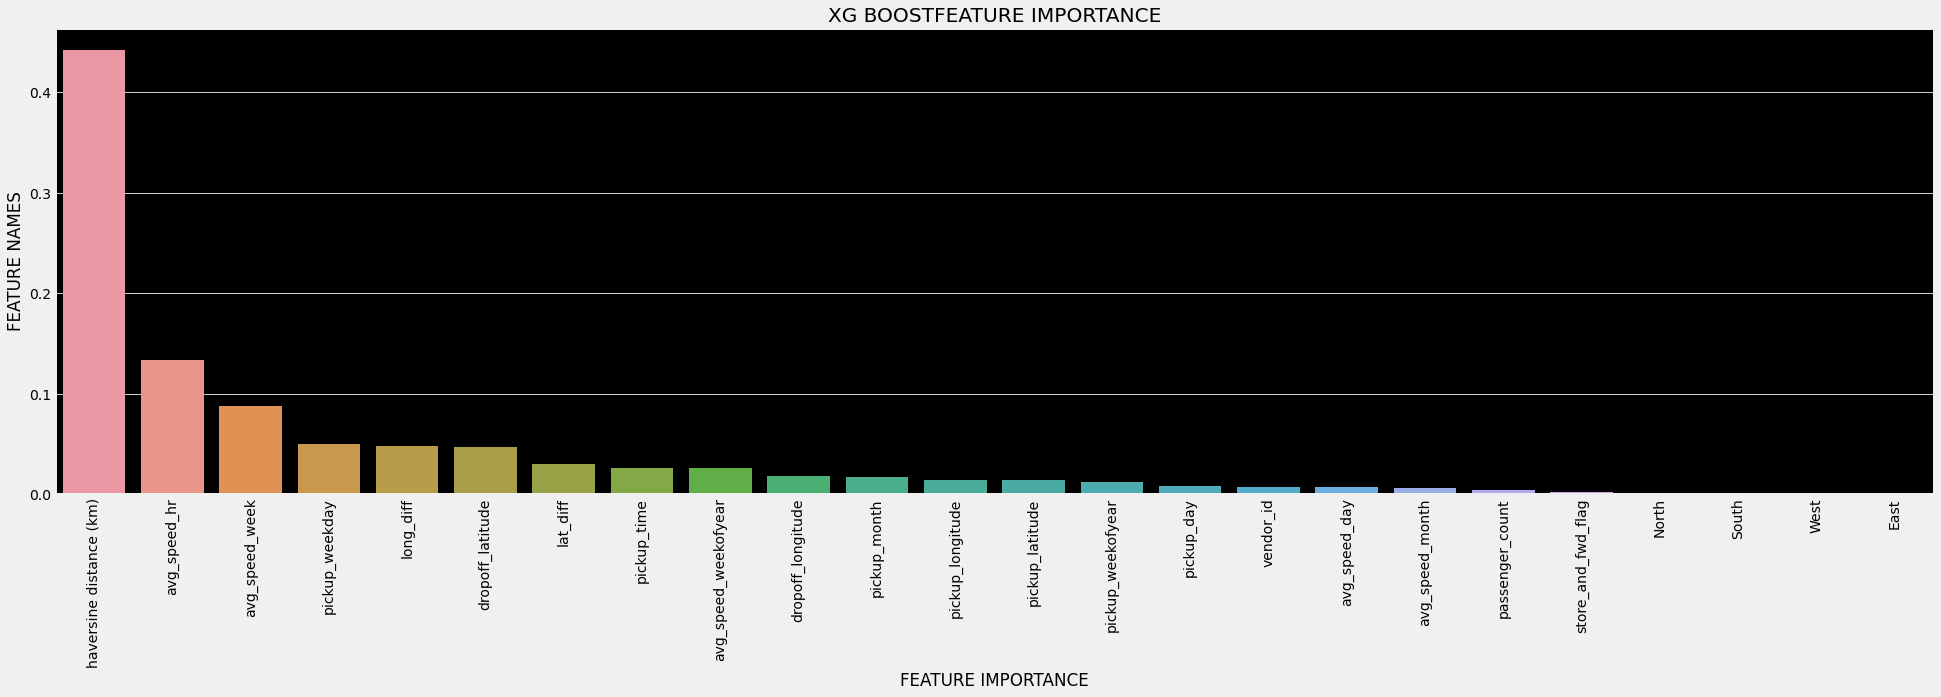

In [59]:
plot_feature_importance(model.feature_importances_,X_train.columns,'XG BOOST')  #Plotting Feature Importance for XGboost

In [60]:
cat_model = CatBoostRegressor(loss_function = "RMSE", eval_metric = "RMSE", metric_period = 1000, iterations=30000,
                        use_best_model = True,
                        random_strength = 0.005,
                        learning_rate=0.1,
                        depth=8,
                        random_seed = 93,                                       # using best set of hyperparameters {'depth': 8, 'iterations': 1000, 'learning_rate': 0.1, 'metric_period': 999, 'od_type': 'Iter', 'od_wait': 200, 'use_best_model': True}
                        l2_leaf_reg = 0.1,
                        verbose=True,
                        logging_level = None,od_type = "Iter",
                        od_wait = 200)
cat_model.fit( X_train, y_train, cat_features=None, eval_set=(X_val,y_val))
y_pred_test_cat=cat_model.predict(X_test)
y_pred_train_cat=cat_model.predict(X_train)
print(f'For learning rate = {0.1}, following are the scores of evaluation metrics:')
print(f'r2 score for test set using  CatRegressor is : {r2_score(y_test,y_pred_test_cat)}')
print('RMSE score for test set using CatRegressor is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test,y_pred_test_cat))))
print(f'r2 score for train set using CatRegressor is : {r2_score(y_train,y_pred_train_cat)}')
print('RMSE score for train set using CatRegressor is : {}'.format(np.sqrt(metrics.mean_squared_error(y_train,y_pred_train_cat))))
# we are able to achieve 80 percent r2 score using this model  

0:	learn: 0.5997657	test: 0.5990692	best: 0.5990692 (0)	total: 273ms	remaining: 2h 16m 33s
1000:	learn: 0.2868437	test: 0.2931178	best: 0.2931178 (1000)	total: 3m 3s	remaining: 1h 28m 35s
2000:	learn: 0.2759523	test: 0.2873881	best: 0.2873849 (1999)	total: 6m 6s	remaining: 1h 25m 26s
3000:	learn: 0.2687324	test: 0.2848217	best: 0.2848185 (2997)	total: 9m 9s	remaining: 1h 22m 21s
4000:	learn: 0.2630056	test: 0.2833288	best: 0.2833288 (4000)	total: 12m 11s	remaining: 1h 19m 14s
5000:	learn: 0.2580569	test: 0.2822319	best: 0.2822313 (4999)	total: 15m 13s	remaining: 1h 16m 5s
6000:	learn: 0.2535898	test: 0.2814923	best: 0.2814920 (5997)	total: 18m 14s	remaining: 1h 12m 57s
7000:	learn: 0.2495599	test: 0.2809683	best: 0.2809683 (7000)	total: 21m 15s	remaining: 1h 9m 50s
8000:	learn: 0.2458865	test: 0.2806061	best: 0.2806007 (7945)	total: 24m 17s	remaining: 1h 6m 47s
9000:	learn: 0.2425000	test: 0.2802837	best: 0.2802825 (8999)	total: 27m 17s	remaining: 1h 3m 40s
10000:	learn: 0.2393018	test

this model is not only fast but much more accurate as well.

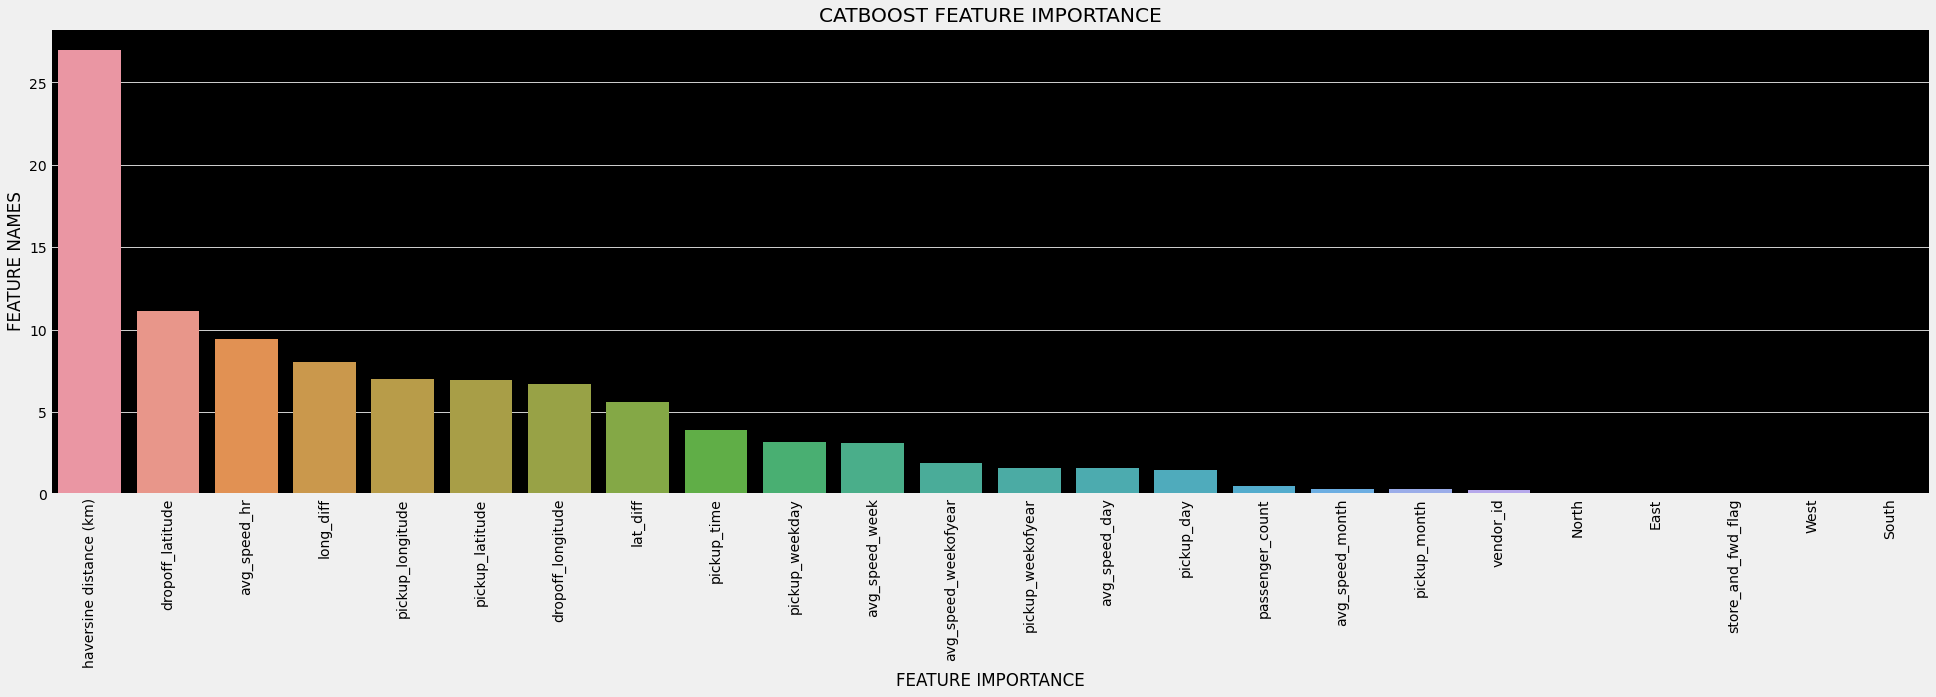

In [61]:
plot_feature_importance(cat_model.get_feature_importance(),X_train.columns,'CATBOOST ') #Plotting Feature Importance for CatBoost Model